In [2]:
import scanpy as sc
import os
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import pickle
import shutil
import numpy as np

from genevector.data import GeneVectorDataset
from genevector.model import GeneVector
from genevector.embedding import GeneEmbedding, CellEmbedding

import grimoire as spell #Library of common analysis methods

import tcri

%matplotlib inline
import matplotlib.pyplot as plt
import os
import sys
import glob
import scanpy as sc
import numpy as np
import pandas as pd
# path to CoNGA repository (downloaded from github); MODIFY FOR YOUR SETUP
CONGA_PATH = '/Users/ceglian/Codebase/conga/'
sys.path.append(CONGA_PATH) 
import conga
from conga.tcrdist.make_10x_clones_file import make_10x_clones_file
# location of the GSE144469 files downloaded from the GEO database; MODIFY FOR YOUR SETUP
DATA_DIR = '/Users/ceglian/Downloads/GSE144469_RAW'
os.chdir(DATA_DIR)

adata = sc.read('/Users/ceglian/Downloads/GSE144469_RAW/merged_gex_abtcr.h5ad')

In [3]:
# this string will be prepended to all CoNGA output files
out_prefix = 'conga_abtcr'


# Store the organism for this analysis in the uns array
# Set organism to 'human' for human alpha-beta TCR analysis
# other options are 'human_gd' 'human_ig' 'mouse' 'mouse_gd'
adata.uns['organism'] = 'human'

# tell CoNGA to annotate results with these batch definitions (present in adata.obs)
# disease_int: 0= +CPI colitis, 1= +CPI no colitis, 2= healthy control 
adata.uns['batch_keys'] = ['disease_int','donor_int']

print('adata.shape:', adata.shape)
print('adata.obs_keys():', adata.obs_keys())

adata.shape: (60655, 33538)
adata.obs_keys(): ['va', 'ja', 'cdr3a', 'cdr3a_nucseq', 'vb', 'jb', 'cdr3b', 'cdr3b_nucseq', 'disease', 'disease_int', 'donor', 'donor_int', 'batch']


In [41]:
conga_result = sc.read("conga_abtcr_final.h5ad")
mapper = dict(zip(conga_result.obs["cdr3b"],conga_result.obs['clusters_tcr']))
ct = []
for x in adata.obs['cdr3b']:
    if x in mapper:
        ct.append(mapper[x])
    else:
        ct.append("None")
adata.obs["tcr_cluster"] = ct
adata = adata[adata.obs['tcr_cluster']!="None"]

In [5]:
adata.layers['count'] = adata.X

In [6]:
# reduce to CD8 cells (see Note 4)
# Perform QC filtering and scale GEX
adata = conga.preprocess.filter_and_scale(
    adata,
    min_genes_per_cell = 500, 
    max_genes_per_cell = 3000,
    max_percent_mito = 0.1
)


adata_cd4, adata_cd8 = conga.devel.split_into_cd4_and_cd8_subsets(
    adata, verbose= True)
adata = adata_cd8

filtered out 1810 cells with more than 3000 genes
filtered out 824 cells with more than 0.1 percent mito
get_feature_types_varname: feature_types feature_type_counts: [('Gene Expression', 18256)]
num antibody features: 0
excluding 161 TR genes (91 variable)
excluding 12 sexlinked genes
total of 621 variable genes (21355, 18256)
Normalize and logging matrix...
get_feature_types_varname: feature_types feature_type_counts: [('Gene Expression', 621)]
feature_types counter: [('Gene Expression', 18256)]
normalize_and_log_the_raw_matrix: adata.raw.X.max()=  20895.0


OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


split_by_CD4_CD8: cluster  0 1839 cd8 cd4:     0.124 cd8:     0.930
split_by_CD4_CD8: cluster  1 1492 cd8 cd4:     0.016 cd8:     1.217
split_by_CD4_CD8: cluster  2 1385 cd8 cd4:     0.000 cd8:     1.106
split_by_CD4_CD8: cluster  3 1255 cd8 cd4:     0.006 cd8:     1.165
split_by_CD4_CD8: cluster  4 1206 cd8 cd4:     0.022 cd8:     1.214
split_by_CD4_CD8: cluster  5 1058 cd8 cd4:     0.007 cd8:     1.276
split_by_CD4_CD8: cluster  6 1011 cd8 cd4:     0.007 cd8:     1.165
split_by_CD4_CD8: cluster  7  996 cd8 cd4:     0.002 cd8:     1.219
split_by_CD4_CD8: cluster  8  987 cd8 cd4:     0.010 cd8:     1.205
split_by_CD4_CD8: cluster  9  873 cd8 cd4:     0.067 cd8:     1.213
split_by_CD4_CD8: cluster 10  850 cd8 cd4:     0.034 cd8:     1.230
split_by_CD4_CD8: cluster 11  813 cd8 cd4:     0.001 cd8:     1.223
split_by_CD4_CD8: cluster 12  705 cd8 cd4:     0.007 cd8:     1.121
split_by_CD4_CD8: cluster 13  697 cd8 cd4:     0.014 cd8:     1.144
split_by_CD4_CD8: cluster 14  659 cd8 cd4:     0

In [7]:
adata.X = adata.layers['count']

In [8]:
#any without signed mi were  false
signed_mi          = True
init_ortho         = True
entropy_threshold  = 1.
mutual_information = "/Users/ceglian/Data/tcri/comparison_{}_{}.p".format(signed_mi,str(entropy_threshold).replace(".",""))
print(mutual_information)
embedding_size     = 100
alpha =0.0
beta =0.0
gain               = 10
c                  = 100
vector_file        = "/Users/ceglian/Data/tcri/comparison_{}_{}_{}_{}_{}_{}.vec".format(embedding_size, alpha, beta, gain, signed_mi, init_ortho)
print(vector_file)
retrain            = False
annotated_h5ad     = "/Users/ceglian/Data/tcri/output.h5ad"
device             = "cpu"

dataset = GeneVectorDataset(adata,load_expression=retrain,signed_mi=signed_mi,device=device)

/Users/ceglian/Data/tcri/comparison_True_10.p
/Users/ceglian/Data/tcri/comparison_100_0.0_0.0_10_True_True.vec
Running...
Skipping expression load.


In [9]:
cmps = GeneVector(dataset,
                    output_file=vector_file,
                    emb_dimension=embedding_size,
                    gain=gain,
                    c=100,
                    init_ortho=init_ortho,
                    device=device)

*****************
Loading Dataset.
*****************



  0%|          | 0/621 [00:00<?, ?it/s]

100%|██████████| 621/621 [00:00<00:00, 3563.87it/s]


Getting gene pairs combinations.
Computing MI for each pair.


100%|██████████| 192510/192510 [01:03<00:00, 3031.58it/s] 


...Directional MI....
MI Loaded.
Loading Batches for Training.


100%|██████████| 621/621 [00:00<00:00, 2781.35it/s]


Ready to train.


In [10]:
cmps.train(4000,threshold=1e-5,alpha=alpha, beta=beta, update_interval=50)

**** Epoch 0 	Loss: 33257.06152
**** Epoch 50 	Loss: 32508.11595
**** Epoch 100 	Loss: 20748.76211
**** Epoch 150 	Loss: 14940.08919
**** Epoch 200 	Loss: 11770.5403
**** Epoch 250 	Loss: 9311.83911
**** Epoch 300 	Loss: 7877.00417
**** Epoch 350 	Loss: 7102.76777
**** Epoch 400 	Loss: 6644.43599
**** Epoch 450 	Loss: 6315.14188
**** Epoch 500 	Loss: 6037.8708
**** Epoch 550 	Loss: 5782.53875
**** Epoch 600 	Loss: 5541.21055
**** Epoch 650 	Loss: 5309.80475
**** Epoch 700 	Loss: 5085.79316
**** Epoch 750 	Loss: 4868.83263
**** Epoch 800 	Loss: 4658.33534
**** Epoch 850 	Loss: 4454.34523
**** Epoch 900 	Loss: 4255.49379
**** Epoch 950 	Loss: 4061.82145
**** Epoch 1000 	Loss: 3872.94904
**** Epoch 1050 	Loss: 3688.68132
**** Epoch 1100 	Loss: 3508.738
**** Epoch 1150 	Loss: 3333.05616
**** Epoch 1200 	Loss: 3161.22291
**** Epoch 1250 	Loss: 2993.59564
**** Epoch 1300 	Loss: 2830.01615
**** Epoch 1350 	Loss: 2670.63549
**** Epoch 1400 	Loss: 2516.11652
**** Epoch 1450 	Loss: 2366.44941
**

In [9]:
embed = GeneEmbedding(vector_file, dataset, vector="average")
cembed = CellEmbedding(dataset, embed)

Loading average of 1st and 2nd weights.


100%|██████████| 621/621 [00:00<00:00, 2812810.78it/s]


100%|██████████| 2687599/2687599 [00:04<00:00, 641730.54it/s]


Generating Cell Vectors.


100%|██████████| 21160/21160 [00:01<00:00, 18649.30it/s]

Found 0 Cells with No Counts.
Finished.


In [10]:
adata = cembed.get_adata()
adata

Loading embedding in X_genevector.
Running Scanpy neighbors and umap.


AnnData object with n_obs × n_vars = 21160 × 621
    obs: 'va', 'ja', 'cdr3a', 'cdr3a_nucseq', 'vb', 'jb', 'cdr3b', 'cdr3b_nucseq', 'disease', 'disease_int', 'donor', 'donor_int', 'batch', 'tcr_cluster', 'n_genes', 'percent_mito', 'n_counts', 'leiden_gex_for_cd4_vs_cd8', 'cd4_or_cd8'
    var: 'gene_ids', 'feature_types', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: 'organism', 'batch_keys', 'conga_results', 'conga_stats', 'log1p', 'hvg', 'raw_matrix_is_logged', 'pca', 'neighbors', 'leiden', 'umap'
    obsm: 'X_pca', 'X_pca_gex', 'X_genevector', 'X_umap'
    varm: 'PCs'
    layers: 'count', 'scaled'
    obsp: 'distances', 'connectivities'

In [11]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from statannot import add_stat_annotation
import matplotlib.patches as mpatches

from gseapy import dotplot
import tqdm

import collections
import operator
import itertools

from tcri.pl import tcri_colors

def top_clone_umap(adata, reduction="umap", top_n=10, fg_alpha=0.9, fg_size=25, bg_size=0.1, bg_alpha=0.6, figsize=(12,5), return_df=False,save=None):
    df = adata.obs
    seq_column = adata.uns["tcri_clone_key"]
    plt.figure(figsize = figsize)
    clonotype_counts = collections.defaultdict(int)
    for clonotype in df[seq_column]:
        clonotype_counts[clonotype] += 1
    top_clonotypes = sorted(clonotype_counts.items(), key=operator.itemgetter(1),reverse=True)
    top_clonotypes = [x[0] for x in top_clonotypes[:top_n]]
    ax1 = plt.subplot(1,1,1)
    x = [x[0] for x in adata.obsm["X_{}".format(reduction)]]
    y = [x[1] for x in adata.obsm["X_{}".format(reduction)]]
    sns.scatterplot(x=x,y=y, color="#75715E",  alpha=bg_alpha, ax=ax1, s=bg_size, linewidth=0.0)
    xonly = []
    yonly = []
    clonotype_labels = []
    size = []
    for clonotype,x1,y1 in zip(df[seq_column],x,y):
        clonotype = str(clonotype)
        if clonotype not in top_clonotypes or clonotype == "None" or clonotype == "nan":
            continue
        else:
            xonly.append(x1)
            yonly.append(y1)
            size.append(1/clonotype_counts[clonotype])
            clonotype_labels.append(str(clonotype) + " {}".format(clonotype_counts[clonotype]))
    dftop = pd.DataFrame.from_dict({"TCR Sequence":clonotype_labels,"Cells":size, "UMAP1":xonly,"UMAP2":yonly})
    colors = tcri_colors + tcri_colors + tcri_colors
    order = []
    for c in set(clonotype_labels):
        if c != "_Other":
            order.append(c)
    colors = colors[:len(set(clonotype_labels))]
    sns.scatterplot(data=dftop, x="UMAP1", y="UMAP2", hue="TCR Sequence", hue_order=order, ax=ax1, alpha=fg_alpha,s=fg_size, linewidth=0.0,palette=colors)
    ax1.set_xlabel('UMAP-1')
    ax1.set_ylabel('UMAP-2')
    ax1.xaxis.set_ticklabels([])
    ax1.yaxis.set_ticklabels([])
    ax1.xaxis.set_ticks([])
    ax1.yaxis.set_ticks([])
    ax1.set_title("Top 10 TCR Clone by Size")
    h,l = ax1.get_legend_handles_labels()
    ax1.legend(h[:top_n-1], l[:top_n-1], borderaxespad=2.,fontsize='9',bbox_to_anchor=(0, 1), loc='best')
    plt.tight_layout()
    if return_df:
        return dftop
    elif save != None:
        plt.savefig(save)


In [12]:
tcri.pp.register_clonotype_key(adata,"cdr3b")

In [16]:


response = {'C1':'PD',
 'C2':'PR',
 'C3':'PR',
 'C4':'PD',
 'C5':'SD',
 'C6':'PR',
 'C7':'PD',
 'C8':'PD',
 'CT1':'Healthy',
 'CT2':'Healthy',
 'CT3':'Healthy',
 'CT4':'Healthy',
 'CT5':'Healthy',
 'CT6':'Healthy',
 'CT7':'Healthy',
 'CT8':'Healthy',
 'NC1':'PR',
 'NC2':'PD',
 'NC3':'PD',
 'NC4':'PR',
 'NC5':'PD',
 'NC6':'PD'}

ct = []
for x in adata.obs["donor"]:
    ct.append(response[x])
adata.obs['response'] = ct

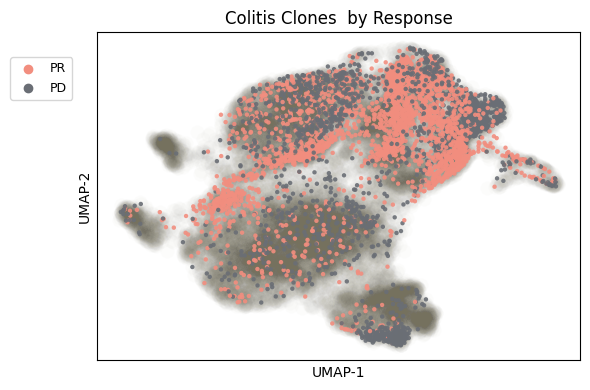

In [17]:
tcri.pp.register_clonotype_key(adata,"cdr3b")
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from statannot import add_stat_annotation
import matplotlib.patches as mpatches

from gseapy import dotplot
import tqdm

import collections
import operator
import itertools

from tcri.pl import tcri_colors

def top_clone_umap(adata, reduction="umap", top_n=10, fg_alpha=0.9, fg_size=25, bg_size=0.1, bg_alpha=0.6, figsize=(12,5), return_df=False,save=None):
    df = adata.obs
    seq_column = adata.uns["tcri_clone_key"]
    plt.figure(figsize = figsize)
    clonotype_counts = collections.defaultdict(int)
    response_dict = dict()
    for clonotype,r,s in zip(df[seq_column],df["disease"],df["response"]):
        if r == "C" and s != "SD":
            clonotype_counts[clonotype] += 1
            response_dict[clonotype] = s
    top_clonotypes = sorted(clonotype_counts.items(), key=operator.itemgetter(1),reverse=True)
    top_clonotypes = [x[0] for x in top_clonotypes[:top_n]]
    ax1 = plt.subplot(1,1,1)
    x = [x[0] for x in adata.obsm["X_{}".format(reduction)]]
    y = [x[1] for x in adata.obsm["X_{}".format(reduction)]]
    sns.scatterplot(x=x,y=y, color="#75715E",  alpha=bg_alpha, ax=ax1, s=bg_size, linewidth=0.0)
    xonly = []
    yonly = []
    clonotype_labels = []
    size = []
    for clonotype,x1,y1 in zip(df[seq_column],x,y):
        clonotype = str(clonotype)
        if clonotype not in top_clonotypes or clonotype == "None" or clonotype == "nan":
            continue
        else:
            xonly.append(x1)
            yonly.append(y1)
            size.append(1/clonotype_counts[clonotype])
            clonotype_labels.append(response_dict[clonotype])         #str(clonotype) + " {}".format(clonotype_counts[clonotype]))
    dftop = pd.DataFrame.from_dict({"TCR Sequence":clonotype_labels,"Cells":size, "UMAP1":xonly,"UMAP2":yonly})
    colors = tcri_colors + tcri_colors + tcri_colors
    order = []
    for c in set(clonotype_labels):
        if c != "_Other":
            order.append(c)
    colors = colors[:len(set(clonotype_labels))]
    sns.scatterplot(data=dftop, x="UMAP1", y="UMAP2", hue="TCR Sequence", hue_order=order, ax=ax1, alpha=fg_alpha,s=fg_size, linewidth=0.0,palette=colors)
    ax1.set_xlabel('UMAP-1')
    ax1.set_ylabel('UMAP-2')
    ax1.xaxis.set_ticklabels([])
    ax1.yaxis.set_ticklabels([])
    ax1.xaxis.set_ticks([])
    ax1.yaxis.set_ticks([])
    ax1.set_title("Colitis Clones  by Response")
    h,l = ax1.get_legend_handles_labels()
    ax1.legend(h[:top_n-1], l[:top_n-1], borderaxespad=2.,fontsize='9',bbox_to_anchor=(0, 1), loc='best')
    plt.tight_layout()
    if return_df:
        return dftop
    elif save != None:
        plt.savefig(save)
top_clone_umap(adata, top_n=1000, fg_size=10, figsize=(6,4),bg_size=100, bg_alpha=0.02, save="/Users/ceglian/colitis.pdf")

In [18]:
sc.pp.normalize_total(adata)
sc.pp.log1p(adata)

In [1]:
from tcri.tl import phenotypic_entropies as pentropies
from tcri.pl import tcri_colors
from tcri.pp import clone_size
def phenotypic_entropy(adata, groupby, splitby, method="probabilistic", return_df=False, normalized=True, decimals=5, figsize=(5,4), save=None, order=None, rotation=0, minimum_clone_size=1, palette=None):
    ps = []
    rs = []
    r2 = []
    ts = []
    for r in set(adata.obs[groupby]):
        rdata = adata[adata.obs[groupby] == r]
        clone_size(rdata)
        rdata = rdata[rdata.obs["clone_size"] >= minimum_clone_size]
        for p in set(rdata.obs[splitby]):
            pdata = rdata[rdata.obs[splitby] == p]
            for clone, ent in pentropies(pdata,method=method,normalized=normalized,decimals=decimals).items():
                rs.append(p)
                r2.append(ent)
                ts.append(clone)
                ps.append(r)
    df = pd.DataFrame.from_dict({groupby:ps,splitby:rs,"Phenotypic Entropy":r2,"Clone":ts})
    fig, ax = plt.subplots(1,1,figsize=figsize)
    if order == None:
        order = list(set(rs))
    if palette == None:
        palette = tcri_colors
    sns.boxplot(data=df, x=splitby,y="Phenotypic Entropy",ax=ax,order=order,palette=palette)
    pairs = list(itertools.combinations(set(df[splitby]),2))
    print(pairs)
    annotator = Annotator(ax, pairs=pairs, data=df, x=splitby, y="Phenotypic Entropy",order=order)
    annotator.configure(test='Mann-Whitney', text_format='star', loc='outside').apply_and_annotate()
    plt.xticks(rotation=rotation)
    if save!=None:
        fig.savefig(save)
    if return_df:
        return df
tcri.pp.clone_size(adata)
xdata = adata[adata.obs["clone_size"] > 0]
# xdata = xdata[xdata.obs['site'] == "Tumor"]
# tcri.pp.joint_distribution(xdata)
#df = phenotypic_entropy(xdata, groupby="batch",splitby="response_specific",rotation=90, normalized=True, save="/Users/ceglian/smith_phenotypic_entropy_specificity.pdf",minimum_clone_size=3, return_df=True,figsize=(4,3))

# from scipy.stats import ttest_ind
# x = df[df["specificity"] == "Other"]["Phenotypic Entropy"].tolist()
# y = df[df["specificity"] != "Other"]["Phenotypic Entropy"].tolist()
# ttest_ind(x,y,equal_var=False)
xdata = adata[adata.obs["clone_size"] >50]
df = phenotypic_entropy(xdata, groupby="donor",splitby="response",rotation=90, normalized=True, save="/Users/ceglian/comp_phenotypic_entropy_specificity.pdf",minimum_clone_size=3, return_df=True,figsize=(4,3))

NameError: name 'tcri' is not defined

In [22]:
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.preprocessing import MinMaxScaler
import seaborn as sns
import matplotlib.pyplot as plt
import pandas
import tqdm
import scanpy as sc
import networkx as nx
from sklearn.metrics import confusion_matrix
from scipy.special import softmax
from scipy.spatial import distance
import numpy
from sklearn.preprocessing import StandardScaler
from sklearn.mixture import GaussianMixture
from scipy.sparse import csr_matrix
import numpy as np
import operator
import collections
import os   
import pandas as pd
import gc
from scipy.stats import pearsonr
import numpy as np
import pandas as pd
import seaborn as sns

markers = dict()
markers["Naive/CM"] = ["SELL"]
markers["Activated"] = ["GZMB"]
markers["Memory"] = ["GZMK"]
markers['TRM'] = ["CXCR6"]
markers["Dysfunctional"] = ["TIGIT"]
markers["NK-like"] = ["KLRB1"]

def cell_distance(self, vec, norm=True):
    # matrix = self.matrix
    # if norm:
    #     vec /= np.linalg.norm(vec)
    #     print("norm")
    #     matrix = normalize(matrix)
    mapped_components = dict(zip(list(self.data.keys()),self.matrix))
    odists = []
    for x in tqdm.tqdm(self.adata.obs.index):
        cell_vec = mapped_components[x]
        # if norm:
        #     cell_vec /= np.linalg.norm(cell_vec)
        dist = 1. - distance.cosine(cell_vec, vec)
        odists.append(dist)
    return odists

class bcolors:
    HEADER = '\033[95m'
    OKBLUE = '\033[94m'
    OKCYAN = '\033[96m'
    OKGREEN = '\033[92m'
    WARNING = '\033[93m'
    FAIL = '\033[91m'
    ENDC = '\033[0m'
    BOLD = '\033[1m'
    UNDERLINE = '\033[4m'

from sklearn import preprocessing

def phenotype_probability(self, adata, phenotype_markers, return_distances=False, method="sparsemax", target_col="genevector", temperature=0.05, normalize=True):
    """
    Probablistically assign phenotypes based on a set of cell type labels and associated markers. 
    Can optionally return the original cosine distances and perform the assignment based on expression weight gene vectors.
    Loads into the anndata the pseudo-probabilities for each cell type and the deterministic label taken from the maximum probability over cell types.

    :param adata: anndata object generated from "get_adata", has "X_genevector" in the obsm dataframe.
    :type column: anndata.AnnData
    :param phenotype_markers: Dictionary of cell type labels (key) to gene markers used to define the cell type as a list (value).
    :type phenotype_markers: dict
    :param return_distances: Change the return type to a tuple that includes a dictionary containing the actual cosine distances alongside the phenotype probabilities.
    :type column: bool
    :param expression_weighted: Compute similarit to each cell using the expression weightedy marker gnene vector.
    :type column: bool
    :param target_col: Column label to load in deterministic cell asssignments in the obs data frame of the anndata object.
    :type target_col: bool
    :return: Anndata with cell type labels and probabilities, or optionally a tuple with the anndata and the raw cosine similarities.
    :rtype:  anndata.AnnData
    """
    if method == "softmax":
        print(bcolors.OKBLUE+"Using **SoftMax**"+bcolors.ENDC)
        pfunc = softmax
    elif method == "sparsemax":
        print(bcolors.OKBLUE+"Using **SparseMax**"+bcolors.ENDC)
        pfunc = self.entmax_15
    elif method == "normalized_exponential":
        print(bcolors.OKBLUE+"Using Normalized Exponential (Temp: {})".format(temperature)+bcolors.ENDC)
        pfunc = lambda x: self.normalized_exponential_vector(x, temperature)
    for x in adata.obs.columns:
        if "Pseudo-probability" in x:
            del adata.obs[x]
    mapped_components = dict(zip(list(self.data.keys()),self.matrix))
    genes = adata.var.index.to_list()
    cells = adata.obs.index.to_list()
    all_markers = []
    for _, markers in phenotype_markers.items():
        all_markers += markers  
    all_markers = list(set(all_markers))
    probs = dict()

    for pheno, markers in phenotype_markers.items():
        print(bcolors.OKBLUE+"Computing similarities for {}".format(pheno)+bcolors.ENDC)
        print(bcolors.OKGREEN+"Markers: {}".format(", ".join(markers))+bcolors.ENDC)
        vector = self.embed.generate_vector(markers)
        probs[pheno] = cell_distance(self, vector,norm=normalize)
    distribution = []
    celltypes = []
    for k, v in probs.items():
        distribution.append(v)
        celltypes.append(k)
    distribution = np.array(distribution)
    distribution = preprocessing.normalize(distribution)
    distribution = list(zip(*distribution))
    probabilities = []
    for d in distribution:
        p = pfunc(numpy.array(d))
        probabilities.append(p)
    
    res = {"distances":distribution, "order":celltypes, "probabilities":probabilities}
    barcode_to_label = dict(zip(list(self.data.keys()), res["probabilities"]))
    ct = []
    probs = collections.defaultdict(list)
    for x in adata.obs.index:
        ctx = res["order"][numpy.argmax(barcode_to_label[x])]
        ct.append(ctx)
        for ph, pb in zip(res["order"],barcode_to_label[x]):
            probs[ph].append(pb)
    adata.obs[target_col] = ct
    def load_predictions(adata,probs):
        prob_cols = []
        for ph in probs.keys():
            prob_cols.append(ph+" Pseudo-probability")
            adata.obs[ph+" Pseudo-probability"] = probs[ph]
        adata.uns["probability_columns"] = prob_cols
        return adata
    adata = load_predictions(adata, probs)
    if return_distances:
        return adata, res
    else:
        return adata

adata, dist = phenotype_probability(cembed, adata, markers, method="normalized_exponential", temperature=0.001, return_distances=True, normalize=True)

Using Normalized Exponential (Temp: 0.001)
Computing similarities for Naive/CM
Markers: SELL


100%|██████████| 21160/21160 [00:00<00:00, 67477.96it/s]


Computing similarities for Activated
Markers: GZMB


100%|██████████| 21160/21160 [00:00<00:00, 70818.01it/s]


Computing similarities for Memory
Markers: GZMK


100%|██████████| 21160/21160 [00:00<00:00, 71409.30it/s]


Computing similarities for TRM
Markers: CXCR6


100%|██████████| 21160/21160 [00:00<00:00, 69817.25it/s]


Computing similarities for Dysfunctional
Markers: TIGIT


100%|██████████| 21160/21160 [00:00<00:00, 70503.03it/s]


Computing similarities for NK-like
Markers: KLRB1


100%|██████████| 21160/21160 [00:00<00:00, 72784.57it/s]


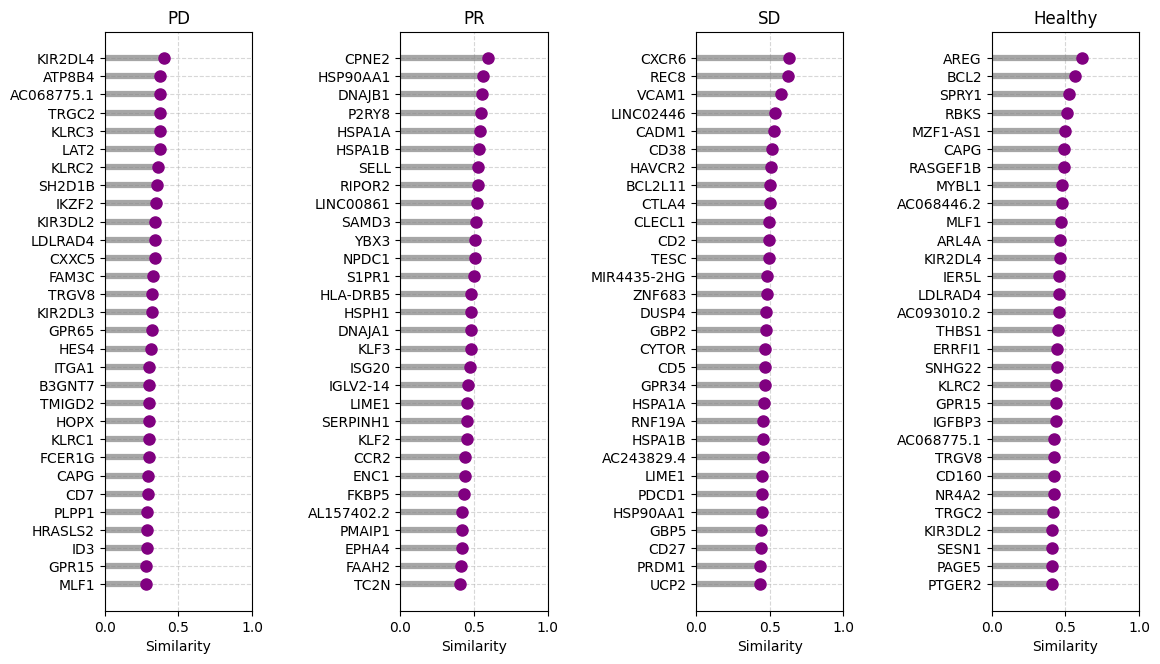

In [23]:
import numpy
import pandas as pd
def get_predictive_genes(self, adata, label, n_genes=10):
    """
    Compute the top n most similar genes to a given variable in the dataset.

    :param adata: anndata object generated from "get_adata", has "X_genevector" in the obsm dataframe.
    :type column: anndata.AnnData
    :param label: Label that defines the cateogies to find predictive genes.
    :type column: str
    :param n_genes: Number of most similar genes to return for each category.
    :type column: int
    :return: The most similar genes to each label stored in a dictionary.
    :rtype:  dict
    """
    vectors = dict()
    mapped_components = dict(zip(list(self.data.keys()),self.matrix))
    comps = collections.defaultdict(list)
    for bc,x in zip(adata.obs.index,adata.obs[label]):
        comps[x].append(mapped_components[bc])
    mean_vecs = []
    for x, vec in comps.items():
        ovecs = []
        vec = numpy.average(vec,axis=0)
        for oph, ovec in comps.items():
            if oph != x:
                ovecs.append(numpy.average(ovec,axis=0))
        aovec = numpy.median(ovecs,axis=0)
        vector = numpy.subtract(vec,aovec)
        # vector = numpy.subtract(vector,self.dataset_vector)
        vectors[x] = vector
    markers = dict()
    for x, mvec in vectors.items():
        ct_sig = self.embed.get_similar_genes(mvec)[:n_genes]
        markers[x] = pd.DataFrame.from_dict(ct_sig)
    return markers

# data = []
# x = get_predictive_genes(cembed, adata,"response",n_genes=30)
# print(x)
# data.append(("MPR",x["MPR"]))
# x = get_predictive_genes(cembed, adata,"specificity",n_genes=30)
# print(x)
# data.append(("MANA",x["MANA"]))
# x = get_predictive_genes(cembed, adata,"response_specific",n_genes=30)
# print(x.keys())
# data.append(("MANA-non-MPR",x["MANA-non-MPR"]))
# x = get_predictive_genes(cembed, adata,"response_specific",n_genes=30)
# print(x)
# data.append(("MANA-MPR",x["MANA-MPR"]))
data = []
for x in get_predictive_genes(cembed, adata, "response",n_genes=30).items():
    if "None" in x[0]: continue
    data.append(x)

fig, axes = plt.subplots(nrows=1, ncols=len(data), figsize=(3 * len(data), 7))

# If there's only one dataframe, axes might not be an array
if len(data) == 1:
    axes = [axes]

color_point = 'purple'
color_line = 'gray'

# Generate each lollipop plot
for ax, df in zip(axes, data):
    label = df[0]
    df = df[1]
    # Sort values for better visualization
    df_sorted = df.sort_values('Similarity', ascending=True)
    ax.hlines(y=df_sorted['Gene'], xmin=0, xmax=df_sorted['Similarity'], color=color_line, alpha=0.7, linewidth=4.5)
    ax.plot(df_sorted['Similarity'], df_sorted['Gene'], 'o', color=color_point, markersize=8)
    ax.set_title(label)
    ax.set_xlabel('Similarity')
    ax.set_xlim(0, 1)  # Assuming similarity scores are between 0 and 1
    ax.grid(True, linestyle='--', alpha=0.5)  # Add grid lines for better readability
    ax.set_axisbelow(True)  # Ensure grid lines are below the plot elements

# Adjust layout to avoid tight squeezing of elements
plt.tight_layout(pad=2.0)

# Show plot
plt.savefig("/Users/ceglian/res.pdf")

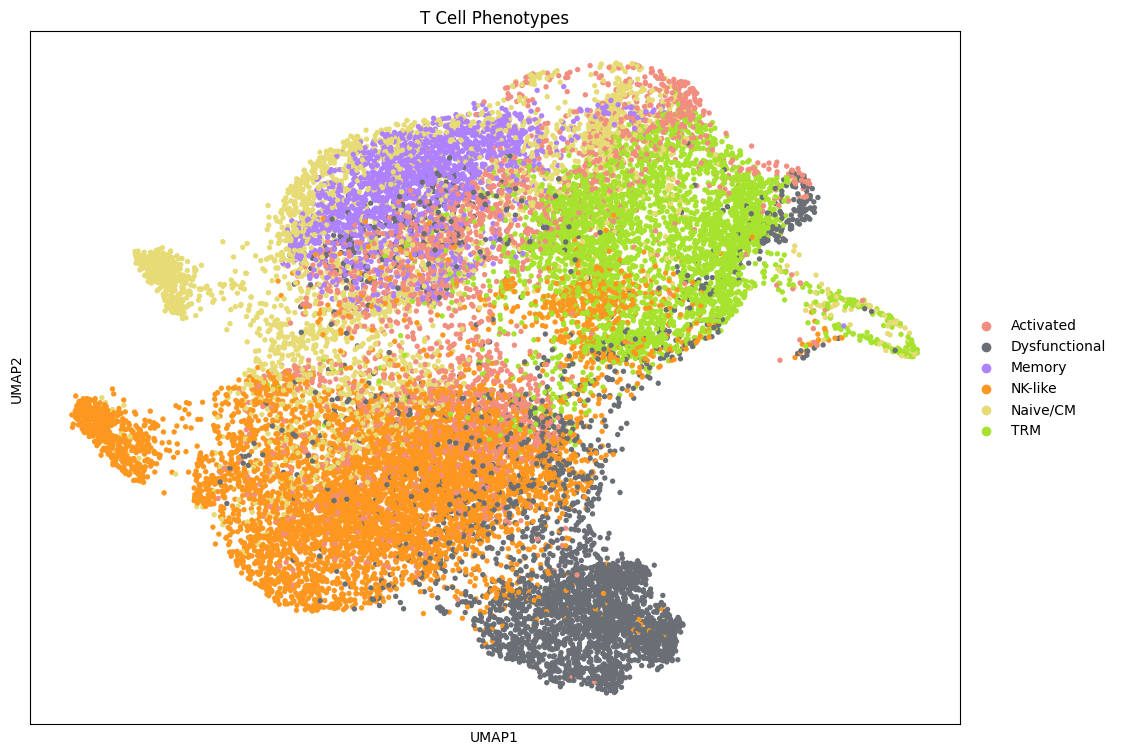

In [24]:
fig, ax = plt.subplots(1,1,figsize=(12,9))
sc.pl.umap(adata,color="genevector",s=60,title="T Cell Phenotypes", add_outline=False,ax=ax, show=False)
fig.savefig("/Users/ceglian/comp_umap.pdf")

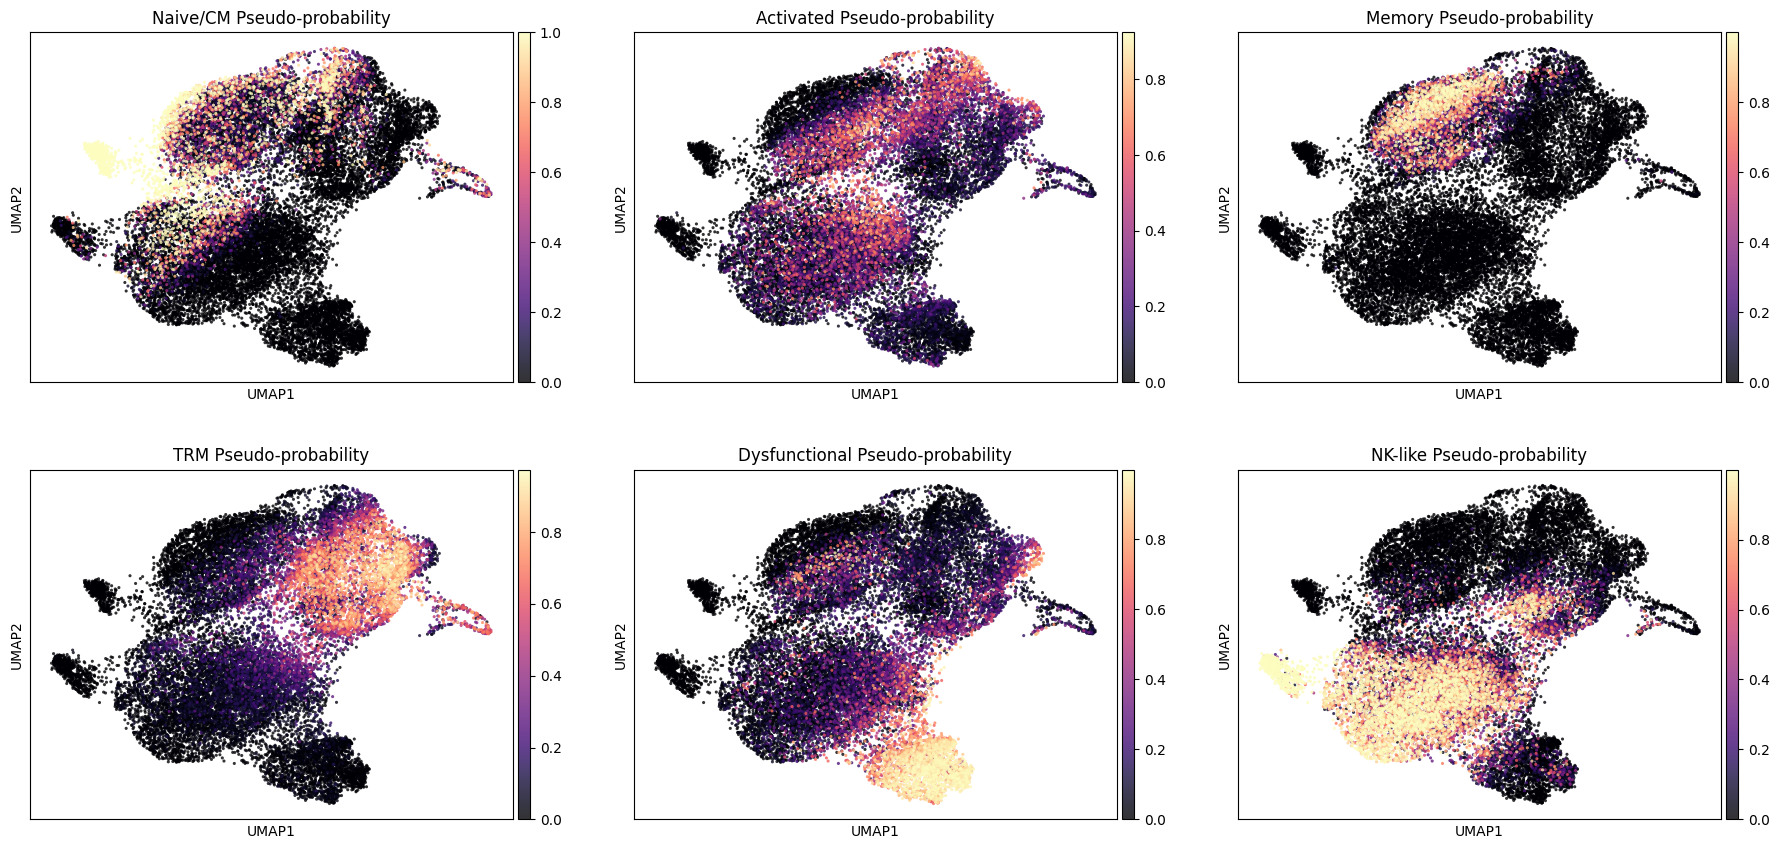

In [229]:
import shutil
sc.pl.umap(adata,color=adata.uns["probability_columns"],s=20,ncols=3,cmap="magma",alpha=0.8,save="probs.pdf")
!cp figures/umapprobs.pdf /Users/ceglian/

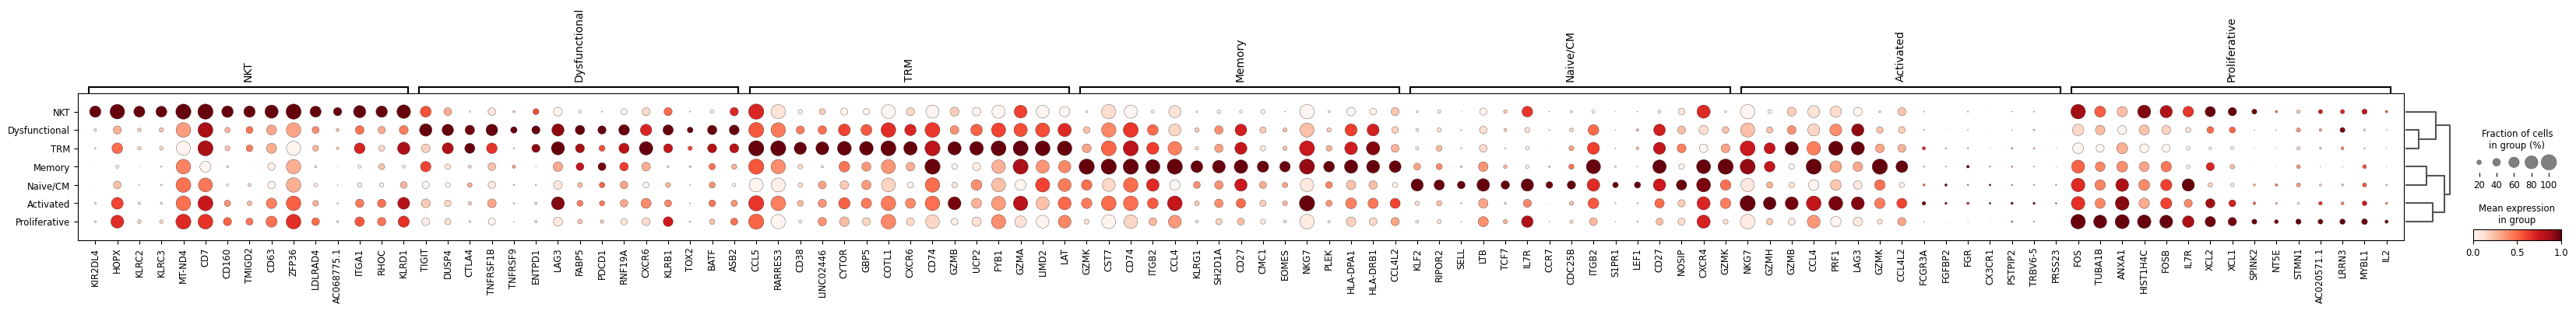

In [134]:
sc.tl.rank_genes_groups(adata,"genevector")
sc.tl.dendrogram(adata,"genevector")
sc.pl.rank_genes_groups_dotplot(adata,min_logfoldchange=1.,standard_scale='var',n_genes=15)

In [190]:
tcri.pp.register_phenotype_key(adata,"genevector")

In [28]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from statannot import add_stat_annotation
import matplotlib.patches as mpatches
from statannotations.Annotator import Annotator
from tcri.pl import tcri_colors

from gseapy import dotplot
import tqdm

import collections
import operator
import itertools

from tcri.utils import Phenotypes, CellRepertoire, Tcell, plot_pheno_sankey, plot_pheno_ternary_change_plots, draw_clone_bars, probabilities
from tcri.preprocessing import clone_size, joint_distribution
from tcri.metrics import clonotypic_entropies as centropies
from tcri.metrics  import phenotypic_entropies as pentropies
from tcri.metrics  import clonality as clonality_tl
from tcri.metrics  import flux as flux_tl
from tcri.metrics  import probability_distribution as pdistribution
from tcri.metrics  import mutual_information as mutual_information_tl
from tcri.metrics  import phenotypic_entropy_delta as phenotypic_entropy_delta_tl
from tcri.metrics  import clone_fraction as clone_fraction_tl


def tcri_boxplot(adata, function, groupby=None,ylabel="", splitby=None,figsize=(8,4),s=20,order=None, hue_order=None, palette=None, add_stats=True):
    if palette == None:
        palette = tcri_colors
    if groupby == None and splitby == None:
        data = function(adata)
        df = pd.DataFrame(list(data.items()), columns=['Phenotype', 'Clonotypic Entropy'])
        df.replace([np.inf, -np.inf], np.nan, inplace=True)
        df.dropna(inplace=True)
        fig,ax=plt.subplots(1,1,figsize=figsize)
        sns.stripplot(data=df,x="Phenotype",y=ylabel,s=s,ax=ax, palette=palette)
        ax.set_ylim(0,max(df[ylabel] + 0.1))
        ax.set_ylabel(ylabel)
        ax.set_title(ylabel)
        fig.tight_layout()
    elif groupby != None and splitby == None:
        groups = adata.obs[groupby].unique()
        dfs = []
        for group in groups:
            data = function(adata[adata.obs[groupby]==group])
            df = pd.DataFrame(list(data.items()), columns=['Phenotype',ylabel])
            df[groupby] = group
            dfs.append(df)
        df = pd.concat(dfs)
        df.replace([np.inf, -np.inf], np.nan, inplace=True)
        df.dropna(inplace=True)
        if order == None:
            order = df.groupby(["Phenotype"]).median(ylabel).sort_values(ylabel).index.tolist()
        fig,ax=plt.subplots(1,1,figsize=figsize)
        sns.stripplot(data=df,x="Phenotype",y=ylabel,s=s,hue=groupby,ax=ax,order=order, palette=palette)
        sns.boxplot(data=df,x="Phenotype",y=ylabel,ax=ax, color="#999999",order=order)

        annotator = Annotator(ax, pairs=[("Thur", "Fri"), ("Fri", "Sat"), ("Sat", "Sun")], data=df, x="day", y="total_bill")
        annotator.configure(test='Mann-Whitney', text_format='star', loc='outside').apply_and_annotate()


        ax.set_ylim(0,max(df[ylabel] + 0.1))
        ax.set_title(ylabel)
        ax.set_ylabel(ylabel)
        sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
        fig.tight_layout()
    elif groupby != None and splitby != None:
        groups = adata.obs[groupby].unique()
        dfs = []
        for group in groups:
            sub = adata[adata.obs[groupby]==group]
            splits = sub.obs[splitby].unique()
            for split in splits:
                data = function(sub[sub.obs[splitby]==split])
                df = pd.DataFrame(list(data.items()), columns=['Phenotype', ylabel])
                df[groupby] = group
                df[splitby] = split
                dfs.append(df)
        df = pd.concat(dfs)
        df.replace([np.inf, -np.inf], np.nan, inplace=True)
        df.dropna(inplace=True)
        fig,ax=plt.subplots(1,1,figsize=figsize)
        if order == None:
            order = df.groupby(["Phenotype"]).median(ylabel).sort_values(ylabel).index.tolist()
        if hue_order == None:
            hue_order = list(sorted(set(df[splitby])))
        print(order)
        if add_stats:
            pairs = []
            hpairs = list(itertools.combinations(hue_order, 2))
            for x in order:
                print(x)
                for z,w in hpairs:
                    pairs.append(((x,z),(x,w)))
                print(pairs)
        print(pairs)
        sns.boxplot(data=df,
                    x="Phenotype",
                    y=ylabel,
                    ax=ax, 
                    hue=splitby,
                    order=order,
                    hue_order=hue_order,
                    palette=palette)
        annotator = Annotator(ax, pairs=pairs, data=df, x="Phenotype", y=ylabel, hue=splitby,order=order, hue_order=hue_order)
        annotator.configure(test='Mann-Whitney', text_format='star', loc='outside').apply_and_annotate()
        ax.set_ylim(0,max(df[ylabel] + 0.1))
        ax.set_title(ylabel)
        sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
        ax.set_ylabel(ylabel)
        fig.tight_layout()
    else:
        raise ValueError("'groupby' must be set to use 'splitby'.")
    return ax

def clonality(adata, groupby = None, splitby=None, s=10, order=None, figsize=(12,5), palette=None):
    return tcri_boxplot(adata,clonality_tl, ylabel="Clonality", groupby=groupby, splitby=splitby, s=s, figsize=figsize, order=order, palette=palette)

def clonotypic_entropy(adata, method="probabilistic", normalized=True, groupby=None, splitby=None, s=10, figsize=(12,5), order=None, palette=None):
    func = lambda x : centropies(x, normalized=normalized, method=method)
    return tcri_boxplot(adata, func, groupby=groupby, ylabel="Clonotypic Entropy", splitby=splitby, s=s, figsize=figsize, order=order, palette=palette)

['Naive/CM', 'TRM', 'Memory', 'Activated', 'NK-like', 'Dysfunctional']
Naive/CM
[(('Naive/CM', 'C'), ('Naive/CM', 'CT')), (('Naive/CM', 'C'), ('Naive/CM', 'NC')), (('Naive/CM', 'CT'), ('Naive/CM', 'NC'))]
TRM
[(('Naive/CM', 'C'), ('Naive/CM', 'CT')), (('Naive/CM', 'C'), ('Naive/CM', 'NC')), (('Naive/CM', 'CT'), ('Naive/CM', 'NC')), (('TRM', 'C'), ('TRM', 'CT')), (('TRM', 'C'), ('TRM', 'NC')), (('TRM', 'CT'), ('TRM', 'NC'))]
Memory
[(('Naive/CM', 'C'), ('Naive/CM', 'CT')), (('Naive/CM', 'C'), ('Naive/CM', 'NC')), (('Naive/CM', 'CT'), ('Naive/CM', 'NC')), (('TRM', 'C'), ('TRM', 'CT')), (('TRM', 'C'), ('TRM', 'NC')), (('TRM', 'CT'), ('TRM', 'NC')), (('Memory', 'C'), ('Memory', 'CT')), (('Memory', 'C'), ('Memory', 'NC')), (('Memory', 'CT'), ('Memory', 'NC'))]
Activated
[(('Naive/CM', 'C'), ('Naive/CM', 'CT')), (('Naive/CM', 'C'), ('Naive/CM', 'NC')), (('Naive/CM', 'CT'), ('Naive/CM', 'NC')), (('TRM', 'C'), ('TRM', 'CT')), (('TRM', 'C'), ('TRM', 'NC')), (('TRM', 'CT'), ('TRM', 'NC')), (('Me

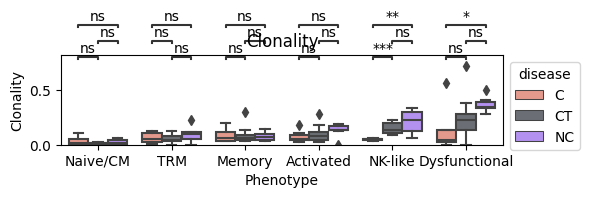

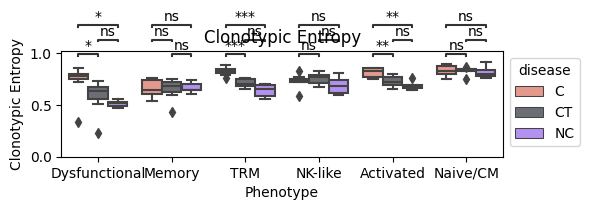

In [302]:

clonality(adata,groupby="donor",splitby="disease",figsize=(6,2.4))
plt.savefig("/Users/ceglian/clonality_response.pdf")
tcri.pp.joint_distribution(adata)
clonotypic_entropy(adata,groupby="donor",splitby="disease",method="probabilistic",figsize=(6,2.4))
plt.savefig("/Users/ceglian/cent_response.pdf")

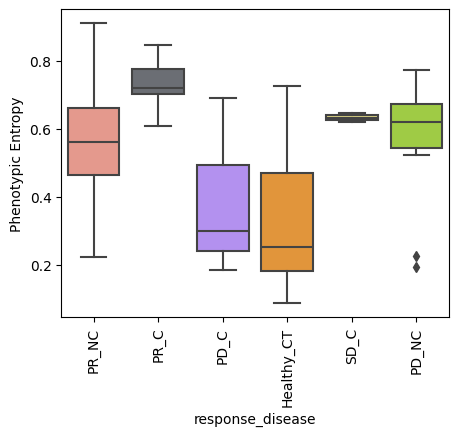

In [295]:
from tcri.tl import phenotypic_entropies as pentropies
from tcri.pl import tcri_colors
def phenotypic_entropy(adata, groupby, splitby, method="probabilistic", return_df=False, normalized=True, decimals=5, figsize=(5,4), save=None, order=None, rotation=0, minimum_clone_size=1, palette=None):
    ps = []
    rs = []
    r2 = []
    ts = []
    for r in set(adata.obs[groupby]):
        rdata = adata[adata.obs[groupby] == r]
        clone_size(rdata)
        rdata = rdata[rdata.obs["clone_size"] >= minimum_clone_size]
        for p in set(rdata.obs[splitby]):
            pdata = rdata[rdata.obs[splitby] == p]
            for clone, ent in pentropies(pdata,method=method,normalized=normalized,decimals=decimals).items():
                rs.append(p)
                r2.append(ent)
                ts.append(clone)
                ps.append(r)
    df = pd.DataFrame.from_dict({groupby:ps,splitby:rs,"Phenotypic Entropy":r2,"Clone":ts})
    fig, ax = plt.subplots(1,1,figsize=figsize)
    if order == None:
        order = list(set(rs))
    if palette == None:
        palette = tcri_colors
    sns.boxplot(data=df, x=splitby,y="Phenotypic Entropy",ax=ax,order=order,palette=palette)
    plt.xticks(rotation=rotation)
    if save!=None:
        fig.savefig(save)
    if return_df:
        return df
    
tcri.pp.clone_size(adata)
xdata = adata[adata.obs["clone_size"] >50]
df = tcri.pl.phenotypic_entropy(xdata, groupby="donor",splitby="response_disease",rotation=90, normalized=True, save="/Users/ceglian/comp_phenotypic_entropy_specificity.pdf",minimum_clone_size=3, return_df=True,figsize=(5,4))

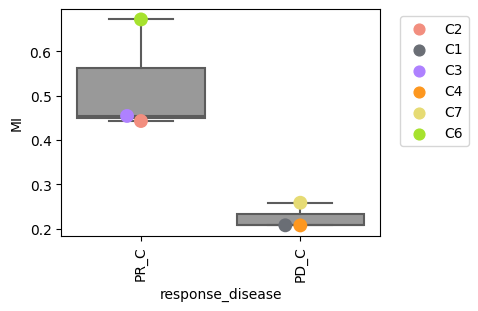

In [216]:
from tcri.tl import mutual_information as mutual_information_tl
from tcri.pp import joint_distribution

# def mutual_information(adata, groupby, splitby=None, method="probabilistic", figsize=(6,5), minimum_clone_size=1, rotation=90,return_df=False,save=None):
#     mis = []
#     groups = []
#     splits = []
#     for group in set(adata.obs[groupby]):
#         gdata = adata[adata.obs[groupby] == group]
#         print("hit")
#         clone_size(gdata)
#         gdata = gdata[gdata.obs["clone_size"] >= minimum_clone_size]
#         if splitby != None:
#             for split in set(gdata.obs[splitby]):
#                 sdata = gdata[gdata.obs[splitby] == split]
#                 mi = mutual_information_tl(sdata, method=method)
#                 mis.append(mi)
#                 groups.append(group)
#                 splits.append(split)
#         else:
#             joint_distribution(gdata)
#             mi = mutual_information_tl(gdata,method=method)
#             mis.append(mi)
#             groups.append(group)
#     df = pd.DataFrame.from_dict({"MI":mis, groupby: groups})
#     if splitby != None:
#         df[splitby] = splits
#     order = list(set(adata.obs[splitby]))

#     fig, ax = plt.subplots(1,1,figsize=figsize)
#     sns.boxplot(data=df,x=splitby,y="MI",ax=ax,order=order)
#     sns.swarmplot(data=df,x=splitby,y="MI",order=order)
#     fig.tight_layout()
#     plt.xticks(rotation=rotation)
#     if save!=None:
#         plt.savefig(save)
#     if return_df:
#         return df
#     else:
#         return ax

import matplotlib.pyplot as plt
xdata = adata[adata.obs["clone_size"] > 10]
xdata = xdata[xdata.obs["response"]!="SD"]
xdata = xdata[xdata.obs["response"]!="Healthy"]
xdata = xdata[xdata.obs["disease"]=="C"]
tcri.pp.joint_distribution(xdata)
df = tcri.pl.mutual_information(xdata,groupby="donor",
                                figsize=(4,3),splitby="response_disease",
                                method="probabilistic",minimum_clone_size=1,
                                return_df=True,bbox_to_anchor=(1.3,1)) #save=
plt.savefig("/Users/ceglian/disease_mutual_info_specificity.pdf")

In [25]:
ct = []
for x,y in zip(adata.obs["response"],adata.obs['disease']):
    ct.append("{}_{}".format(x,y))
adata.obs['response_disease'] = ct

0.3678308331635405
0.387649443991541
0.05637380531270164
0.023304233190744927
0.31882738722569304
0.008527049655226104
0.27404219576158706
1.1102230246251565e-16
0.23607022298242608
0.4531095802101399
0.47314049303749695
0.38299666424430034


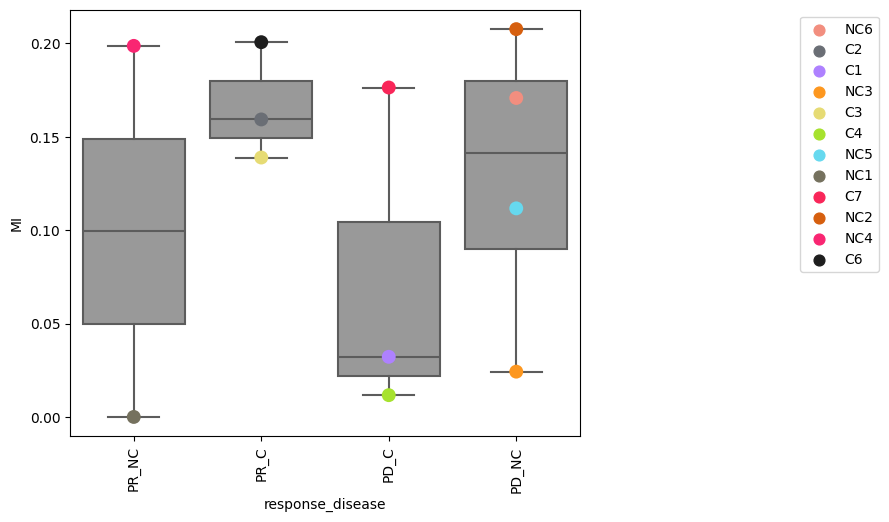

In [205]:
import matplotlib.pyplot as plt
from tcri.tl import mutual_information as mutual_information_tl
from tcri.pp import joint_distribution

import numpy as np

import numpy as np

def entropy(p):
    """ Calculate entropy for a probability distribution. """
    p = p[p > 0]  # Remove zeros to avoid log(0)
    return -np.sum(p * np.log2(p))

def mutual_information_tl(joint_prob):
    """ Calculate mutual information from a joint probability matrix. """
    p_x = np.sum(joint_prob, axis=1)
    p_y = np.sum(joint_prob, axis=0)
    h_x = entropy(p_x)
    h_y = entropy(p_y)
    h_joint = entropy(joint_prob.flatten())
    return h_x + h_y - h_joint

def normalized_mutual_information(joint_prob):
    """ Calculate normalized mutual information from a joint probability matrix. """
    mi = mutual_information_tl(joint_prob)
    print(mi)
    p_x = np.sum(joint_prob, axis=1)
    p_y = np.sum(joint_prob, axis=0)
    h_x = entropy(p_x)
    h_y = entropy(p_y)
    return mi / np.sqrt(h_x * h_y)  # Normalize by the geometric mean of the entropies


def mutual_information(adata, groupby, splitby=None, method="probabilistic", box_color="#999999", size=10, figsize=(6,5), colors=None, minimum_clone_size=0, rotation=90,return_df=False,bbox_to_anchor=(1.15, 1.), order=None):
    mis = []
    groups = []
    splits = []
    for group in set(adata.obs[groupby]):
        gdata = adata[adata.obs[groupby] == group]
        clone_size(gdata)
        gdata = gdata[gdata.obs["clone_size"] >= minimum_clone_size]
        if splitby != None:
            for split in set(gdata.obs[splitby]):
                sdata = gdata[gdata.obs[splitby] == split]
                tcri.pp.joint_distribution(sdata)
                jd = sdata.uns["joint_distribution"].to_numpy()
                mi = normalized_mutual_information(jd / jd.sum())
                mis.append(mi)
                groups.append(group)
                splits.append(split)
        else:
            joint_distribution(gdata)
            mi = mutual_information_tl(gdata,method=method)
            mis.append(mi)
            groups.append(group)
    df = pd.DataFrame.from_dict({"MI":mis, groupby: groups})
    if splitby != None:
        df[splitby] = splits
    if order == None:
        order = list(set(adata.obs[splitby]))
    if colors == None:
        colors = tcri_colors
    fig, ax = plt.subplots(1,1,figsize=figsize)
    sns.boxplot(data=df,x=splitby,y="MI",ax=ax,order=order, color=box_color)
    sns.swarmplot(data=df,x=splitby,y="MI",order=order ,s=size, hue=groupby, palette=colors)
    fig.tight_layout()
    plt.xticks(rotation=rotation)
    _ = ax.legend(loc='upper right', bbox_to_anchor=bbox_to_anchor)
    if return_df:
        return df
    else:
        return ax

from scipy.stats import ttest_ind
import matplotlib.pyplot as plt

xdata = adata[adata.obs["clone_size"] > 20]
xdata = xdata[xdata.obs["response"]!="SD"]
xdata = xdata[xdata.obs["response"]!="Healthy"]

tcri.pp.joint_distribution(xdata)
df = mutual_information(xdata,groupby="donor",
                                figsize=(6,5),splitby="response_disease",
                                method="probabilistic",minimum_clone_size=0,
                                return_df=True,bbox_to_anchor=(1.6,1)) #save=
plt.savefig("/Users/ceglian/disease_mutual_info_specificity.pdf")

In [317]:
for x in trm_genes:
    print(x)

NameError: name 'trm_genes' is not defined

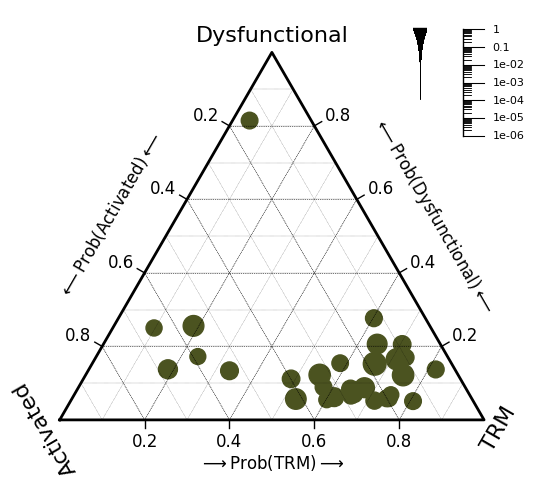

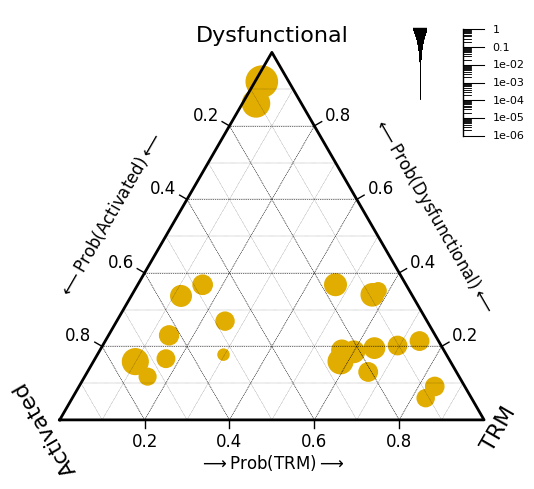

In [304]:
xdata = adata[adata.obs["disease"] == 'C']
xdata = xdata[xdata.obs["clone_size"] > 10]
tcri.pp.joint_distribution(xdata)
tcri.pl.probability_ternary(xdata,phenotype_names=["Dysfunctional","Activated","TRM"], nt=False, method="probabilistic",
             splitby="response",conditions=["PR"], top_n=30,color="#4B5320", scale_function=lambda x :  30*(x**(1/5)),
             save="/Users/ceglian/comp_pr.pdf")
tcri.pl.probability_ternary(xdata,phenotype_names=["Dysfunctional","Activated","TRM"], nt=False, method="probabilistic",
             splitby="response",conditions=["PD"], top_n=30,color="#E1AD01", scale_function=lambda x :  30*(x**(1/5)),
             save="/Users/ceglian/comp_pd.pdf")
# tcri.pl.probability_ternary(xdata,phenotype_names=["Dysfunctional","Activated","TRM"], nt=False, method="probabilistic",
#              splitby="response",conditions=["Healthy"], top_n=60,color="#E1AD01", scale_function=lambda x :  40*(x**(1/5)),
#              save="/Users/ceglian/comp_healthy.pdf")

Activated        0.91533
Dysfunctional    0.88138
Memory           0.44073
NKT              0.70276
Naive/CM         0.75723
Proliferative    0.87604
TRM              0.93470
dtype: float64
Activated        0.82182
Dysfunctional    0.84863
Memory           0.05011
NKT              0.45252
Naive/CM         0.59559
Proliferative    0.85012
TRM              0.80375
dtype: float64
Activated        0.71073
Dysfunctional    0.67062
Memory           0.38447
NKT              0.57718
Naive/CM         0.59362
Proliferative    0.77850
TRM              0.74805
dtype: float64
Activated        0.826030
Dysfunctional    0.824280
Memory           0.059215
NKT              0.582135
Naive/CM         0.628320
Proliferative    0.818875
TRM              0.832625
dtype: float64


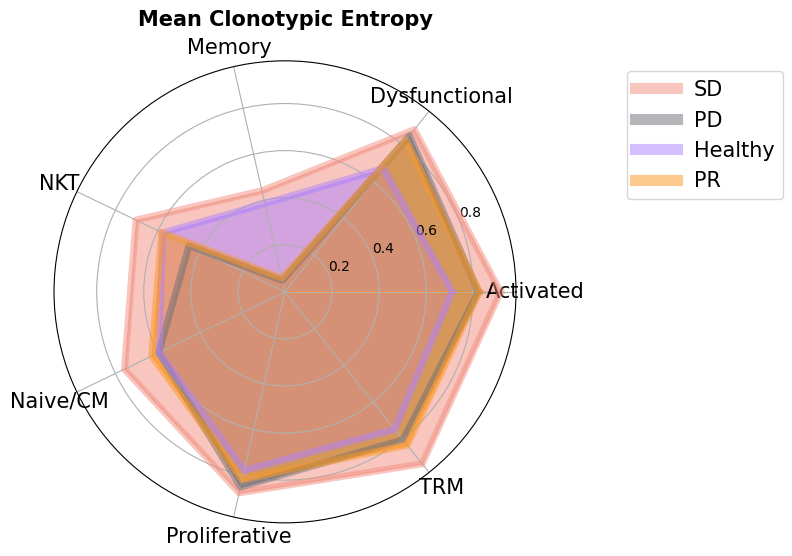

In [150]:
def polar_plot(adata, phenotypes=None, statistic="entropy", method="probabilistic", save=None, figsize=(6,6), title=None, alpha=0.6, fontsize=15, splitby=None, bbox_to_anchor=(1.15,1.), linewidth=5., legend_fontsize=15, color_dict=None):
    tcri.pp.joint_distribution(adata,method=method )
    plt.figure(figsize=figsize)
    ax = plt.subplot(111, projection='polar')
    if splitby is None:
        splits = ['All']
    else:
        splits = list(set(adata.obs[splitby]))
    if phenotypes is None:
        phenotypes = adata.uns["joint_distribution"].index
    N = len(phenotypes)
    theta = np.linspace(0.0, 2 * np.pi, N, endpoint=False)
    plot_theta = np.append(theta, theta[0])
    adata = adata[adata.obs[adata.uns["tcri_phenotype_key"]].isin(phenotypes)]
    for i, split in enumerate(splits): 
        if color_dict == None:
            colorx = tcri.pl.tcri_colors[i]
        else:
            colorx = color_dict[split]
        psubset = adata[adata.obs[splitby] == split]
        pdists = []
        for p in set(psubset.obs["batch"]):
            ppsubset = psubset[psubset.obs["batch"] == p]
            if len(ppsubset.obs.index) < 10: continue
            tcri.pp.joint_distribution(ppsubset)
            if statistic == "entropy":
                pdist = pd.Series(tcri.tl.clonotypic_entropies(ppsubset,normalized=True))
                phenotypes = pdist.index.tolist()
                pdists.append(pdist)
            else:    
                pdist = pdistribution(psubset, method=method)
            pdists.append(pdist)
        pdist = pd.DataFrame(pdists).T
        pdist = pdist.median(axis=1)
        print(pdist)
        pdist = pdist.tolist()
        pdist.append(pdist[0])
        ax.plot(plot_theta, pdist, color=colorx, alpha=alpha, label=split, linewidth=linewidth)
        ax.fill_between(plot_theta, 0, pdist, color=colorx, alpha=alpha)
    ax.set_xticks(theta)
    ax.set_xticklabels(phenotypes, fontsize=fontsize)
    ax.grid(True)
    leg = ax.legend(loc='upper right', bbox_to_anchor=bbox_to_anchor, fontsize=legend_fontsize)
    for line in leg.get_lines():
        line.set_linewidth(8.0)  # Set the line width
    if title:
        plt.title(title, va='bottom', fontsize=fontsize, fontweight="bold")
    if save:
        plt.savefig(save)

sub = adata[adata.obs["clone_size"] > 20]
tcri.pp.joint_distribution(sub)
polar_plot(sub, splitby="response",statistic="entropy", title="Mean Clonotypic Entropy",save="/Users/ceglian/comp_ent.pdf", alpha=0.5, bbox_to_anchor=(1.6,1))

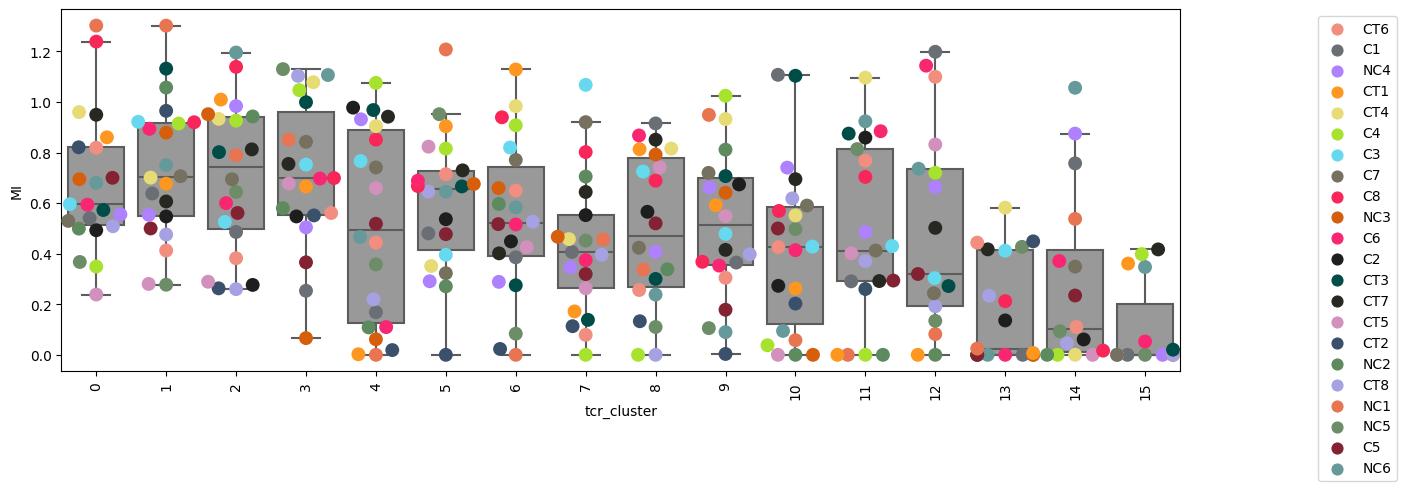

In [26]:
from tcri.tl import mutual_information as mutual_information_tl
from tcri.pp import joint_distribution

# def mutual_information(adata, groupby, splitby=None, method="probabilistic", figsize=(6,5), minimum_clone_size=1, rotation=90,return_df=False,save=None):
#     mis = []
#     groups = []
#     splits = []
#     for group in set(adata.obs[groupby]):
#         gdata = adata[adata.obs[groupby] == group]
#         print("hit")
#         clone_size(gdata)
#         gdata = gdata[gdata.obs["clone_size"] >= minimum_clone_size]
#         if splitby != None:
#             for split in set(gdata.obs[splitby]):
#                 sdata = gdata[gdata.obs[splitby] == split]
#                 mi = mutual_information_tl(sdata, method=method)
#                 mis.append(mi)
#                 groups.append(group)
#                 splits.append(split)
#         else:
#             joint_distribution(gdata)
#             mi = mutual_information_tl(gdata,method=method)
#             mis.append(mi)
#             groups.append(group)
#     df = pd.DataFrame.from_dict({"MI":mis, groupby: groups})
#     if splitby != None:
#         df[splitby] = splits
#     order = list(set(adata.obs[splitby]))

#     fig, ax = plt.subplots(1,1,figsize=figsize)
#     sns.boxplot(data=df,x=splitby,y="MI",ax=ax,order=order)
#     sns.swarmplot(data=df,x=splitby,y="MI",order=order)
#     fig.tight_layout()
#     plt.xticks(rotation=rotation)
#     if save!=None:
#         plt.savefig(save)
#     if return_df:
#         return df
#     else:
#         return ax

import matplotlib.pyplot as plt
xdata = adata[adata.obs["clone_size"] > 1]
tcri.pp.joint_distribution(xdata)
df = tcri.pl.mutual_information(xdata,groupby="donor",
                                figsize=(12,5),splitby="tcr_cluster",
                                method="probabilistic",minimum_clone_size=1,
                                return_df=True,bbox_to_anchor=(1.2,1)) #save=
plt.savefig("/Users/ceglian/Data/tcri/disease_mutual_info_specificity.pdf")

In [42]:
full = adata.copy()

In [65]:
adata = full.copy()
tcri.pp.register_clonotype_key(adata,"tcr_cluster")
tcri.pp.joint_distribution(adata)
observed_MI_clu = compute_mutual_information(adata.uns['joint_distribution'].to_numpy())

adata = full.copy()
tcri.pp.register_clonotype_key(adata,"cdr3b")
tcri.pp.joint_distribution(adata)
observed_MI_tcr = compute_mutual_information(adata.uns['joint_distribution'].to_numpy())

observed_MI_clu

0.02242550031991275

In [68]:
def entropy(p):
    """ Calculate entropy for a probability distribution. """
    p = p[p > 0]  # Remove zeros to avoid log(0)
    return -np.sum(p * np.log2(p))

def mutual_information_tl(joint_prob):
    """ Calculate mutual information from a joint probability matrix. """
    p_x = np.sum(joint_prob, axis=1)
    p_y = np.sum(joint_prob, axis=0)
    h_x = entropy(p_x)
    h_y = entropy(p_y)
    h_joint = entropy(joint_prob.flatten())
    return h_x + h_y - h_joint

def normalized_mutual_information(joint_prob):
    """ Calculate normalized mutual information from a joint probability matrix. """
    mi = mutual_information_tl(joint_prob)
    p_x = np.sum(joint_prob, axis=1)
    p_y = np.sum(joint_prob, axis=0)
    h_x = entropy(p_x)
    h_y = entropy(p_y)
    return mi / np.sqrt(h_x * h_y)  # Normalize by the geometric mean of the entropies

adata = full.copy()
tcri.pp.register_clonotype_key(adata,"tcr_cluster")
tcri.pp.joint_distribution(adata)
jd = adata.uns['joint_distribution'].to_numpy()
observed_MI_clu = normalized_mutual_information(jd/jd.sum())

adata = full.copy()
tcri.pp.register_clonotype_key(adata,"cdr3b")
tcri.pp.joint_distribution(adata)
jd = adata.uns['joint_distribution'].to_numpy()
observed_MI_tcr = normalized_mutual_information(jd/jd.sum())

print(observed_MI_clu, observed_MI_tcr)

0.032353158100992374
1.2719948713039013
0.010655776936751547 0.2359074668042745


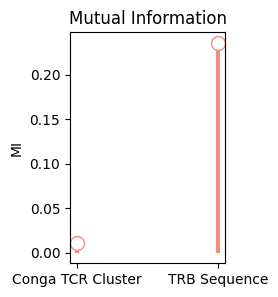

In [84]:
import matplotlib.pyplot as plt

# Data
values = [observed_MI_clu, observed_MI_tcr]
categories = ['Conga TCR Cluster', 'TRB Sequence']
plt.figure(figsize=(2,3))
# Create lollipop plot
(markerline, stemlines, baseline) = plt.stem(categories, values, basefmt=" ")
plt.setp(markerline, 'markerfacecolor', '#FFFFFF', 'markersize', 10)  # Set marker size and color
plt.setp(stemlines, 'linewidth', 3)  # Set stem line width

plt.xlabel('')
plt.ylabel('MI')
plt.title('Mutual Information')
plt.savefig("/Users/ceglian/lolli.pdf")

In [89]:
set(adata.obs["donor"])

{'C1',
 'C2',
 'C3',
 'C4',
 'C5',
 'C6',
 'C7',
 'C8',
 'CT1',
 'CT2',
 'CT3',
 'CT4',
 'CT5',
 'CT6',
 'CT7',
 'CT8',
 'NC1',
 'NC2',
 'NC3',
 'NC4',
 'NC5',
 'NC6'}

0.0009799147827145305
0.0012380021387645712
0.0012852081717342756
0.0011296593141523203
0.0008742954668559122
0.0008506971653616802
0.0012313876876595131
0.0006800316103632298
0.0010473668428740979
0.0007105095413493245
Observed MI: 0.02242550031991275
P-value: 0.0


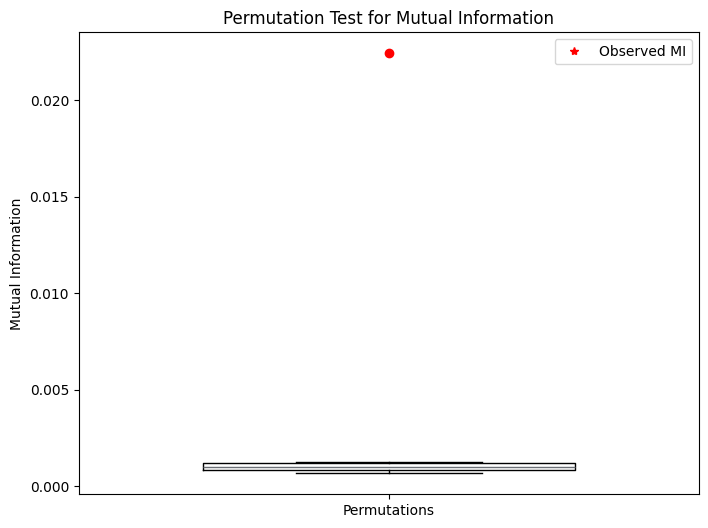

In [64]:
import numpy as np
from scipy.stats import entropy
adata = full.copy()
def compute_mutual_information(joint_distribution):
    # Calculate marginal distributions
    p_x = joint_distribution.sum(axis=1)
    p_y = joint_distribution.sum(axis=0)
    
    # Calculate joint entropy
    H_xy = entropy(joint_distribution.flatten())
    
    # Calculate marginal entropies
    H_x = entropy(p_x)
    H_y = entropy(p_y)
    
    # Mutual information
    MI = H_x + H_y - H_xy
    return MI

def permutation_test(adata, n_permutations=10):
    adata = adata[adata.obs["clone_size"]>0]
    tcri.pp.register_clonotype_key(adata,"tcr_cluster")
    tcri.pp.joint_distribution(adata)
    observed_MI = compute_mutual_information(adata.uns['joint_distribution'].to_numpy())
    
    permuted_MIs = []
    labels = adata.obs['tcr_cluster'].values  # Adjust 'labels' to your specific label column
    for _ in range(n_permutations):
        np.random.shuffle(labels)
        adata.obs['tcr_cluster'] = labels
        tcri.pp.register_clonotype_key(adata,"tcr_cluster")
        tcri.pp.joint_distribution(adata)
        
        # Re-compute the joint distribution here if necessary, or adjust the existing one
        # This is a placeholder for your method to compute the joint distribution
        # adata.uns['joint_distribution'] = compute_joint_distribution(adata)
        
        permuted_MI = compute_mutual_information(adata.uns['joint_distribution'].to_numpy())
        permuted_MIs.append(permuted_MI)
        print(permuted_MI)
    
    # Calculate p-value
    p_value = np.sum(permuted_MIs >= observed_MI) / n_permutations
    return observed_MI, permuted_MIs, p_value


result = permutation_test(adata)
print("Observed MI:", result[0])
print("P-value:", result[2])

import matplotlib.pyplot as plt

def plot_permutation_results(observed_MI, permuted_MIs):
    plt.figure(figsize=(8, 6))
    plt.boxplot(permuted_MIs, positions=[1], widths=0.6)
    plt.scatter([1], [observed_MI], color='red', zorder=5)  # Highlight observed MI
    plt.title('Permutation Test for Mutual Information')
    plt.ylabel('Mutual Information')
    plt.xticks([1], ['Permutations'])
    plt.plot([], [], 'r*', label='Observed MI')
    plt.legend()
    plt.show()

# Assuming the permutation test has been run and results are stored as follows
# observed_MI, permuted_MIs, p_value = permutation_test(adata)
# Now plot the results
plot_permutation_results(result[0], result[1])

In [36]:
result[1]

[0.8816796587310058,
 0.8816796587310058,
 0.8816796587310058,
 0.8816796587310058,
 0.8816796587310058,
 0.8816796587310058,
 0.8816796587310058,
 0.8816796587310058,
 0.8816796587310058,
 0.8816796587310058,
 0.8816796587310058,
 0.8816796587310058,
 0.8816796587310058,
 0.8816796587310058,
 0.8816796587310058,
 0.8816796587310058,
 0.8816796587310058,
 0.8816796587310058,
 0.8816796587310058,
 0.8816796587310058,
 0.8816796587310058,
 0.8816796587310058,
 0.8816796587310058,
 0.8816796587310058,
 0.8816796587310058,
 0.8816796587310058,
 0.8816796587310058,
 0.8816796587310058,
 0.8816796587310058,
 0.8816796587310058,
 0.8816796587310058,
 0.8816796587310058,
 0.8816796587310058,
 0.8816796587310058,
 0.8816796587310058,
 0.8816796587310058,
 0.8816796587310058,
 0.8816796587310058,
 0.8816796587310058,
 0.8816796587310058,
 0.8816796587310058,
 0.8816796587310058,
 0.8816796587310058,
 0.8816796587310058,
 0.8816796587310058,
 0.8816796587310058,
 0.8816796587310058,
 0.8816796587

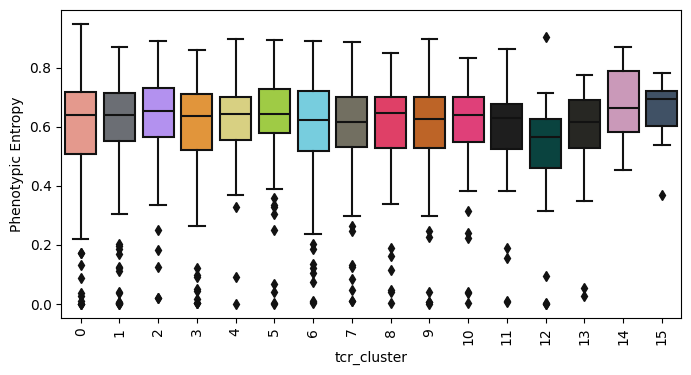

In [152]:
df = tcri.pl.phenotypic_entropy(adata, groupby="donor",splitby="tcr_cluster",rotation=90, normalized=True, save="/Users/ceglian/Data/tcri/comp_phenotypic_entropy_specificity.pdf",minimum_clone_size=3, return_df=True,figsize=(8,4))

In [250]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.spatial.distance import cityblock, cosine
from scipy.stats import mannwhitneyu

# # Generate synthetic data
# np.random.seed(42)
# num_clones = 50
# num_features = 10  # Number of features in the probability distribution

# # Simulating probability distributions for each clone
# prob_distributions = np.random.dirichlet(np.ones(num_features), num_clones)

# # Assigning clones to clusters randomly for demonstration
# clusters = np.random.choice(['Cluster 1', 'Cluster 2', 'Cluster 3'], num_clones)
# clone_data = pd.DataFrame(prob_distributions, columns=[f'Feature_{i}' for i in range(num_features)])
# clone_data['Cluster'] = clusters

# type(clone_data)

U-statistic: 17459370.5, P-value: 0.1593923680987573


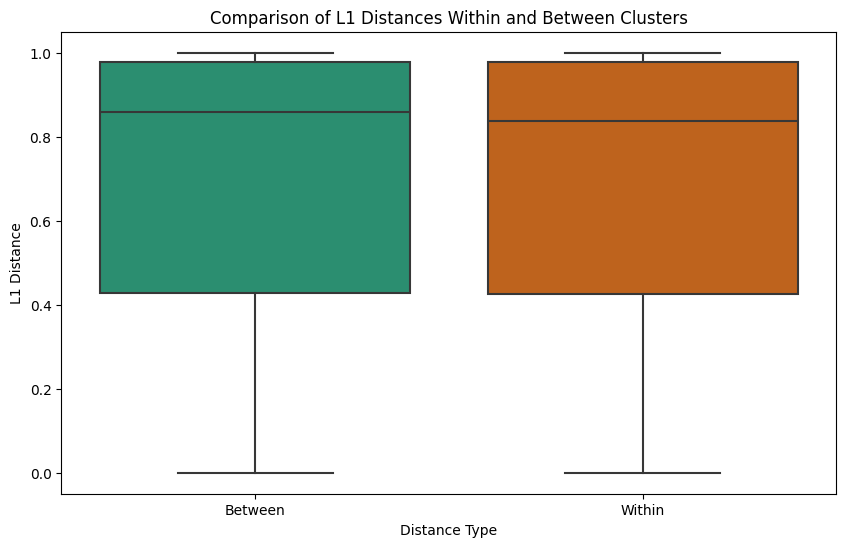

In [251]:
jd = adata.uns["joint_distribution"] / adata.uns["joint_distribution"].sum(axis=0)
mapper = dict(zip(adata.obs['cdr3b'],adata.obs["tcr_cluster"]))
clone_data = pd.DataFrame(jd.T)
ct = []
for x in clone_data.index:
    ct.append(mapper[x])
clone_data['Cluster'] = ct
clone_data

# Calculating L1 distances
distances = []
labels = []
num_clones = 200#len(clone_data.index)
for i in range(num_clones):
    for j in range(i + 1, num_clones):
        distance = cosine(clone_data.iloc[i, :-1], clone_data.iloc[j, :-1])
        same_cluster = clone_data.iloc[i, -1] == clone_data.iloc[j, -1]
        distances.append(distance)
        labels.append('Within' if same_cluster else 'Between')

# Statistical comparison
distance_df = pd.DataFrame({'Distance': distances, 'Label': labels})
u_stat, p_value = mannwhitneyu(distance_df[distance_df['Label'] == 'Within']['Distance'],
                               distance_df[distance_df['Label'] == 'Between']['Distance'],
                               alternative='less')

print(f"U-statistic: {u_stat}, P-value: {p_value}")

# Plotting
plt.figure(figsize=(10, 6))
sns.boxplot(data=distance_df, x='Label', y='Distance')
plt.title('Comparison of L1 Distances Within and Between Clusters')
plt.xlabel('Distance Type')
plt.ylabel('L1 Distance')
plt.show()

In [255]:
for p in set(adata.obs["genevector"]):
    mapper = dict(zip(jd.T.index,jd.T[p]))
    ct = []
    for x in conga_result.obs["cdr3b"]:
        if x in mapper:
            ct.append(mapper[x])
        else:
            ct.append(0)
    conga_result.obs[p] = ct
ct

[0.10556000000000001,
 0.00037,
 0.7712,
 0.00393,
 0.04434044340443404,
 0.32127678723212766,
 0.00072,
 0.061145,
 0.07645923540764592,
 0.8746912530874691,
 0.023720237202372027,
 0.04922,
 0.02750972490275097,
 0.062450624506245056,
 0.21341666666666667,
 0.13578932105339475,
 0.47876760616196923,
 0.249551,
 0.00512,
 0.024540245402454024,
 0.00473,
 0.13072717318206706,
 0.005130000000000001,
 0.10050366834556115,
 0.07271072710727107,
 0.09117091170911709,
 0.13078869211307886,
 0.23978952042095916,
 0.121905,
 0.0846815495450708,
 0.06468,
 0.17904,
 0.05254052540525405,
 0.0,
 0.05118,
 6.999930000699992e-05,
 0.05254236864407838,
 0.16128,
 0.207765,
 0.07647076470764708,
 0.043960000000000006,
 0.08668,
 0.2545200000000001,
 0.010140101401014009,
 0.0,
 0.22636460909229872,
 0.06186,
 0.11449,
 0.02237,
 0.0,
 0.07044929550704493,
 0.01552,
 0.10026899731002689,
 0.19851399504665018,
 0.0,
 0.00347,
 0.00631,
 0.03530035300353004,
 0.11881365629546878,
 0.1782041089794551,
 

In [55]:
adata = full.copy()
tcri.pp.register_clonotype_key(adata,"cdr3b")
tcri.pp.joint_distribution(adata)
pents = tcri.tl.phenotypic_entropies(adata)
ct = []
for x in conga_result.obs["cdr3b"]:
    if x in pents:
        ct.append(pents[x])
    else:
        ct.append(0)
conga_result.obs["Phenotypic Entropy"] = ct

In [56]:
pents

{'CAAETRSPTEAFF': 0.0,
 'CAAFSGRLAGELFF': 7e-05,
 'CAAGPGEDNEQFF': 0.494,
 'CAAGTGRRRTDTQYF': 0.36869,
 'CAAGTGSFGYTF': 0.43557,
 'CAAGTHDSNQPQHF': 0.03952,
 'CAARATNTGELFF': 0.5023,
 'CAASIGGETQYF': 0.12676,
 'CACLEDRGSGNTIYF': 0.37825,
 'CACPGQGDEKLFF': 0.00543,
 'CACQVRVNSNQPQHF': 0.51413,
 'CACRSEETQYF': 0.405,
 'CACRTENRAGYTF': 0.72279,
 'CACRTGTDTQYF': 0.00841,
 'CAEGGGGGYGYTF': 0.0,
 'CAEGRASAGELFF': 0.14903,
 'CAEGTSLSEQFF': 0.75233,
 'CAEQGGGRDTEAFF': 0.44901,
 'CAGGGEGQFF': 0.52754,
 'CAGGGGDGNQPQHF': 0.64532,
 'CAGGGQGLNTEAFF': 0.33262,
 'CAGGSPNEQFF': 0.0,
 'CAGGTGDSNQPQHF': 0.89185,
 'CAGKTDSYNEQFF': 0.0042,
 'CAGPLAGVYNEQFF': 0.02627,
 'CAGQGPRYYGYTF': 0.53673,
 'CAGQTSVPYEQYF': 0.05224,
 'CAGREEINEKLFF': 0.8339,
 'CAGREPMNTEAFF': 0.95733,
 'CAGRFEAPGHTF': 0.19762,
 'CAGRGQGGSYEQYF': 0.00227,
 'CAGRLGDTEAFF': 0.0,
 'CAGRSGANVLTF': 0.39685,
 'CAGSERENTEAFF': 0.44131,
 'CAGSPGGTDTQYF': 0.25421,
 'CAGTDRNTEAFF': 0.5138,
 'CAGTTSNEQFF': 0.16063,
 'CAGTYGTGSLEQYF': 0.2427,
 'C

(2410, 6)


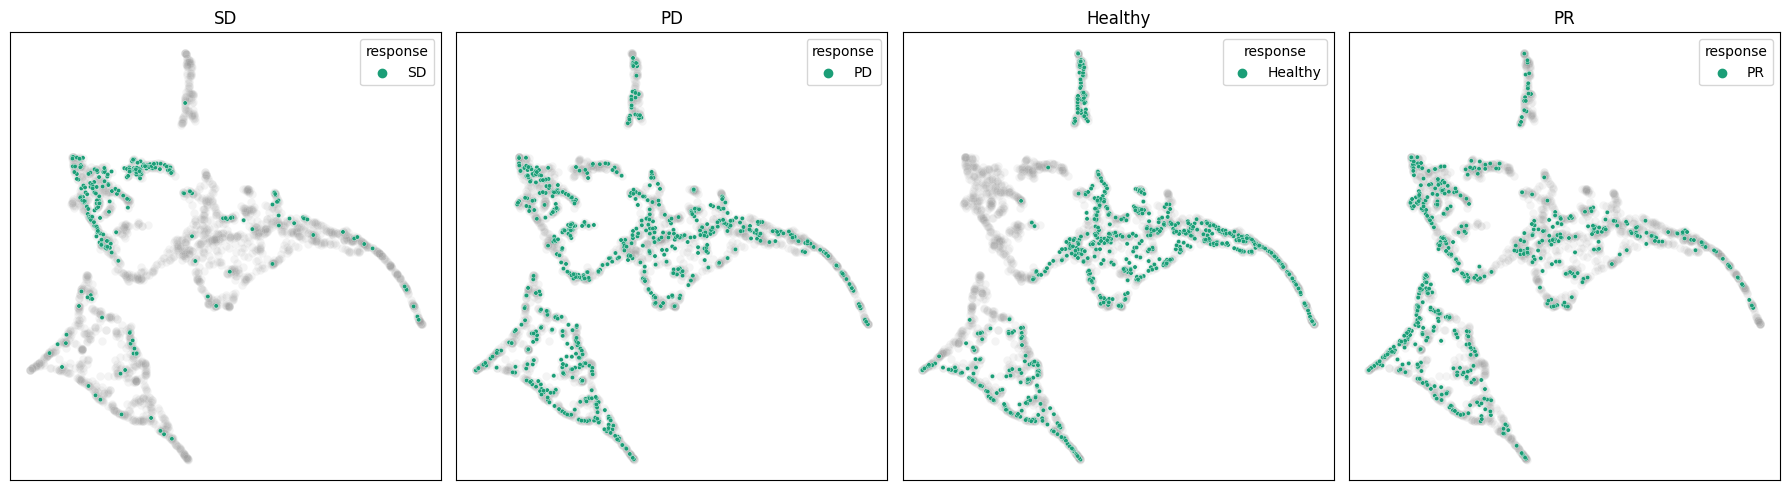

In [243]:
import numpy as np
import umap
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster



sub = adata.copy()
sub = adata[adata.obs["clone_size"] > 1]
tcri.pp.joint_distribution(sub)
mat = sub.uns["joint_distribution"] / sub.uns["joint_distribution"].sum(axis=0)
mat = mat.T

df = pd.DataFrame(mat)
print(df.shape)
# Initialize UMAP. n_neighbors and min_dist are important parameters to tune
reducer = umap.UMAP(n_neighbors=15, min_dist=0.1, n_components=2, random_state=42)

# Fit the model to your data
embedding = reducer.fit_transform(mat)

mapper = dict(zip(adata.obs["cdr3b"],adata.obs["response"]))
rows = []
for x in df.index:
    r = mapper[x]
    if "None" in str(r):
        rows.append("_None")
    else:
        rows.append(str(r))
dat = tcri.tl.phenotypic_entropies(adata)
ct = []
for x in df.index:
    ct.append(dat[x])
df["entropy"] = ct
df["response"] = rows


df["x"] =  embedding[:, 0]
df["y"] =  embedding[:, 1]


fig, ax=plt.subplots(1,len(set(adata.obs["response"])),figsize=(18, 5))
# sns.scatterplot(data=df, x="x", y="y",alpha=0.9,hue="Naive/CM",ax=ax[0],legend=None)
# ax[0].set_title("Naive/CM Probability")
# sns.scatterplot(data=df, x="x", y="y",alpha=0.9,hue="Memory",ax=ax[1],legend=None)
# ax[1].set_title("Memory Probability")
# sns.scatterplot(data=df, x="x", y="y",alpha=0.9,hue="Dysfunctional",ax=ax[2],legend=None)
# ax[2].set_title("Dysfunctional")
# sns.scatterplot(data=df, x="x", y="y",alpha=0.9,hue="Activated",ax=ax[3],legend=None)
# ax[3].set_title("Activated Probability")
# sns.scatterplot(data=df, x="x", y="y",alpha=0.9,hue="TRM",ax=ax[4],legend=None)
# ax[4].set_title("TRM Probability")
i = 0
for x in set(adata.obs["response"]):
    sns.scatterplot(data=df, x="x", y="y",alpha=0.1,color="#999999",ax=ax[i])
    scatter = sns.scatterplot(data=df[df["response"]==x], x="x", y="y", hue="response",s=10,ax=ax[i])
    scatter.set_title(x)
    i += 1
    #scatter.legend(loc='center left', bbox_to_anchor=(1, 0.5))
#ax[5].set_title("Antigen Reactivity")


for axis in ax:
    axis.set_xticks([])
    axis.set_yticks([])
    axis.set_xlabel('')
    axis.set_ylabel('')

fig.tight_layout()
fig.savefig("/Users/ceglian/clonemap.pdf")

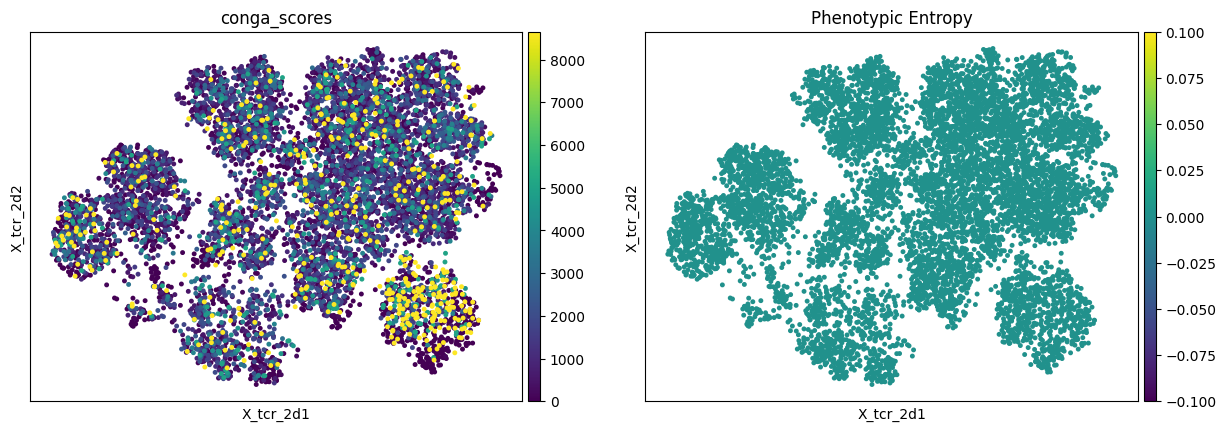

In [53]:
sc.pl.embedding(conga_result, basis='X_tcr_2d', color=['conga_scores','Phenotypic Entropy'],s=50, save="phenotypic_ent.pdf")
!cp figures/X_tcr_2dphenotypic_ent.pdf /Users/ceglian/

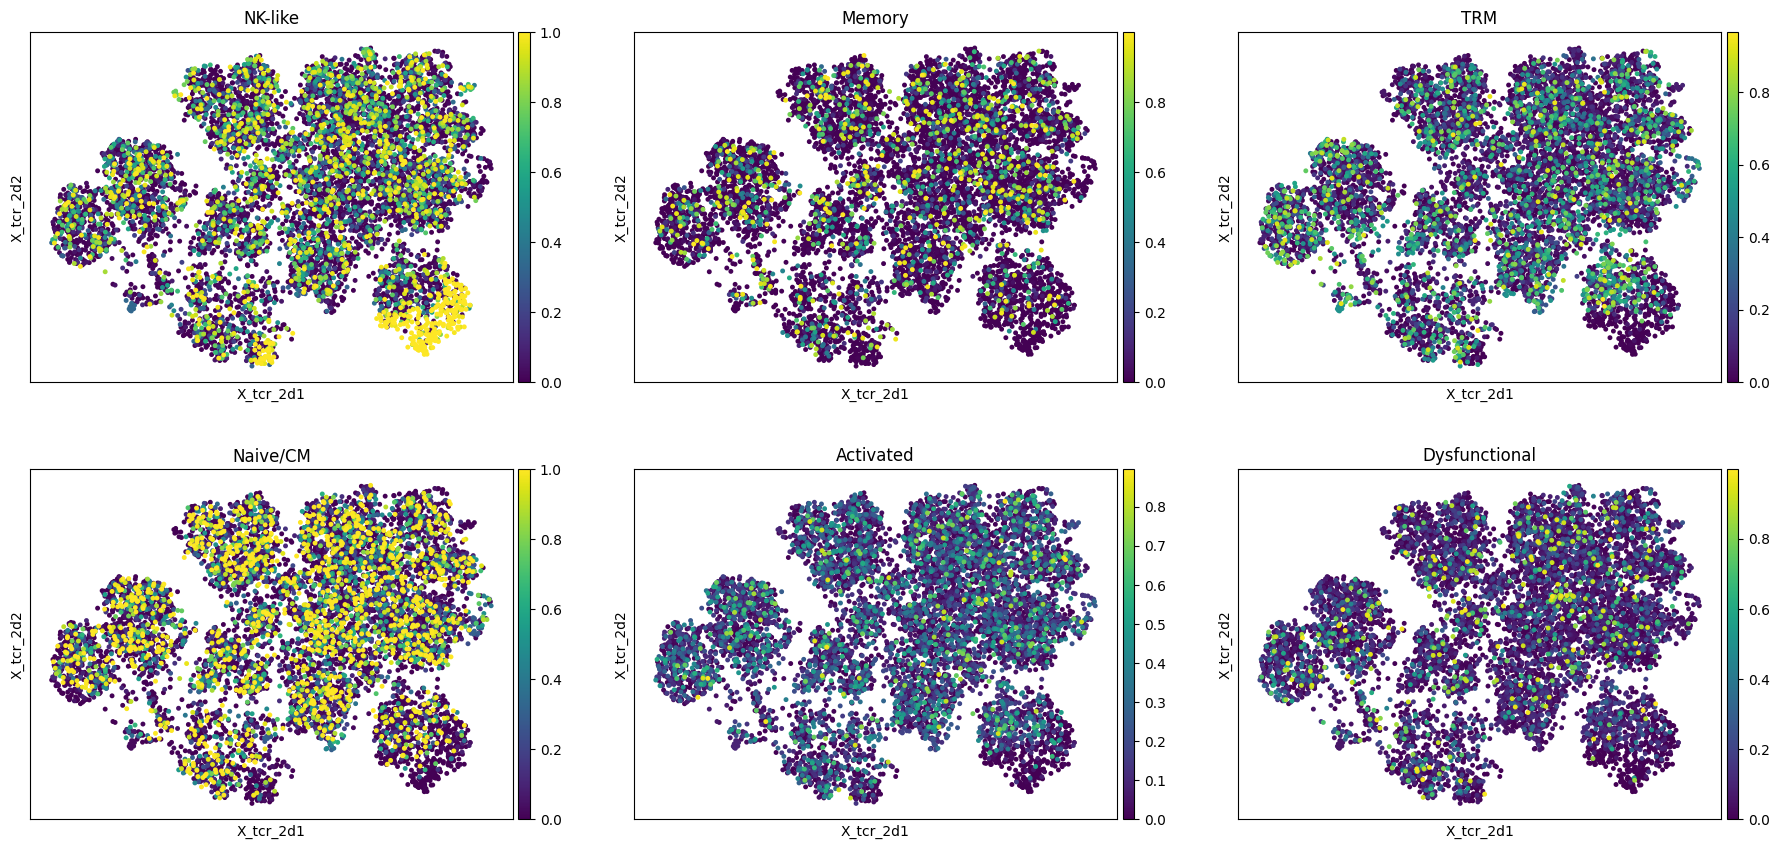

In [257]:
sc.pl.embedding(conga_result, basis='X_tcr_2d', color=list(set(adata.obs['genevector'])),s=50,ncols=3)

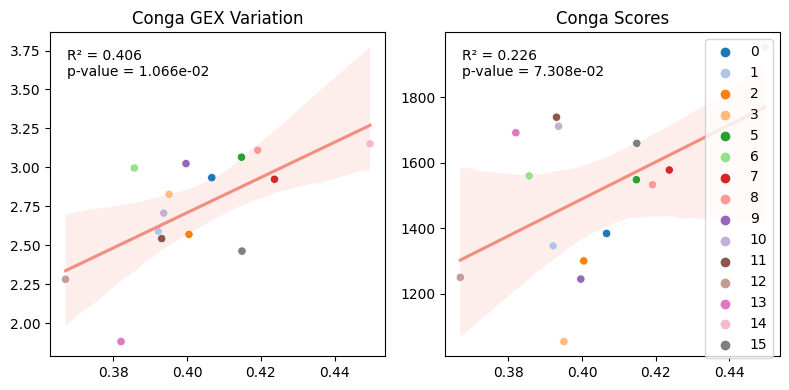

In [57]:
from scipy import stats
x = []
y = []
z = []
w = []
for c in set(conga_result.obs["clusters_tcr"]):
    if str(c) == "4": continue
    sub = conga_result[conga_result.obs['clusters_tcr'] == c]
    x.append(np.mean(sub.obs["Phenotypic Entropy"]))
    y.append(np.mean(sub.obs["gex_variation"]))
    w.append(np.mean(sub.obs["conga_scores"]))
    z.append(str(c))
fig, ax = plt.subplots(1, 2, figsize=(8, 4))

# First subplot
sns.regplot(x=x, y=y, ax=ax[0], scatter=False)
sns.scatterplot(x=x, y=y, hue=z, ax=ax[0], legend=None, palette="tab20")
ax[0].set_title("Conga GEX Variation")

# Calculate the linear regression and stats
slope, intercept, r_value, p_value, std_err = stats.linregress(x, y)
r_squared = r_value**2
ax[0].text(0.05, 0.95, f'R² = {r_squared:.3f}\np-value = {p_value:.3e}', transform=ax[0].transAxes, verticalalignment='top')

# Second subplot
sns.regplot(x=x, y=w, ax=ax[1], scatter=False)
sns.scatterplot(x=x, y=w, hue=z, ax=ax[1], palette="tab20")
ax[1].set_title("Conga Scores")

# Calculate the linear regression and stats for the second plot
slope, intercept, r_value, p_value, std_err = stats.linregress(x, w)
r_squared = r_value**2
ax[1].text(0.05, 0.95, f'R² = {r_squared:.3f}\np-value = {p_value:.3e}', transform=ax[1].transAxes, verticalalignment='top')

fig.tight_layout()
plt.savefig("/Users/ceglian/conga.pdf")

In [51]:
x

[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]

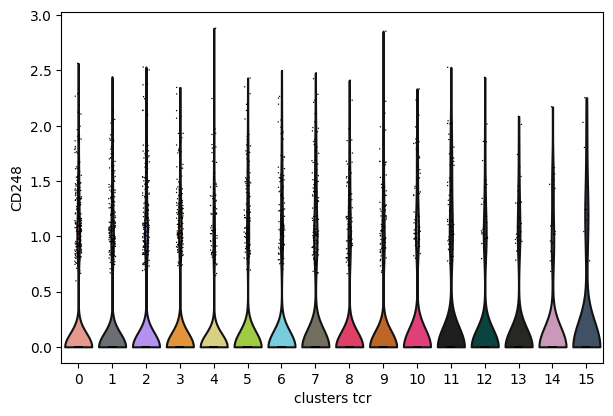

In [366]:
conga_result.obs["clusters_tcr"] = [str(x) for x in conga_result.obs["clusters_tcr"]]
sc.pl.violin(conga_result,"CD248",groupby="clusters_tcr")

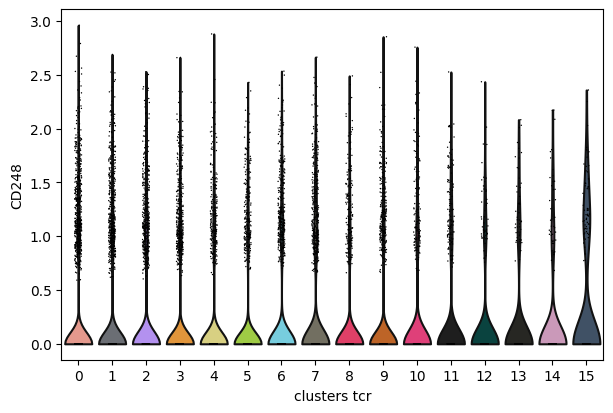

In [367]:
adata.obs["clusters_tcr"] = [str(x) for x in adata.obs["tcr_cluster"]]
sc.pl.violin(adata,"CD248",groupby="clusters_tcr")

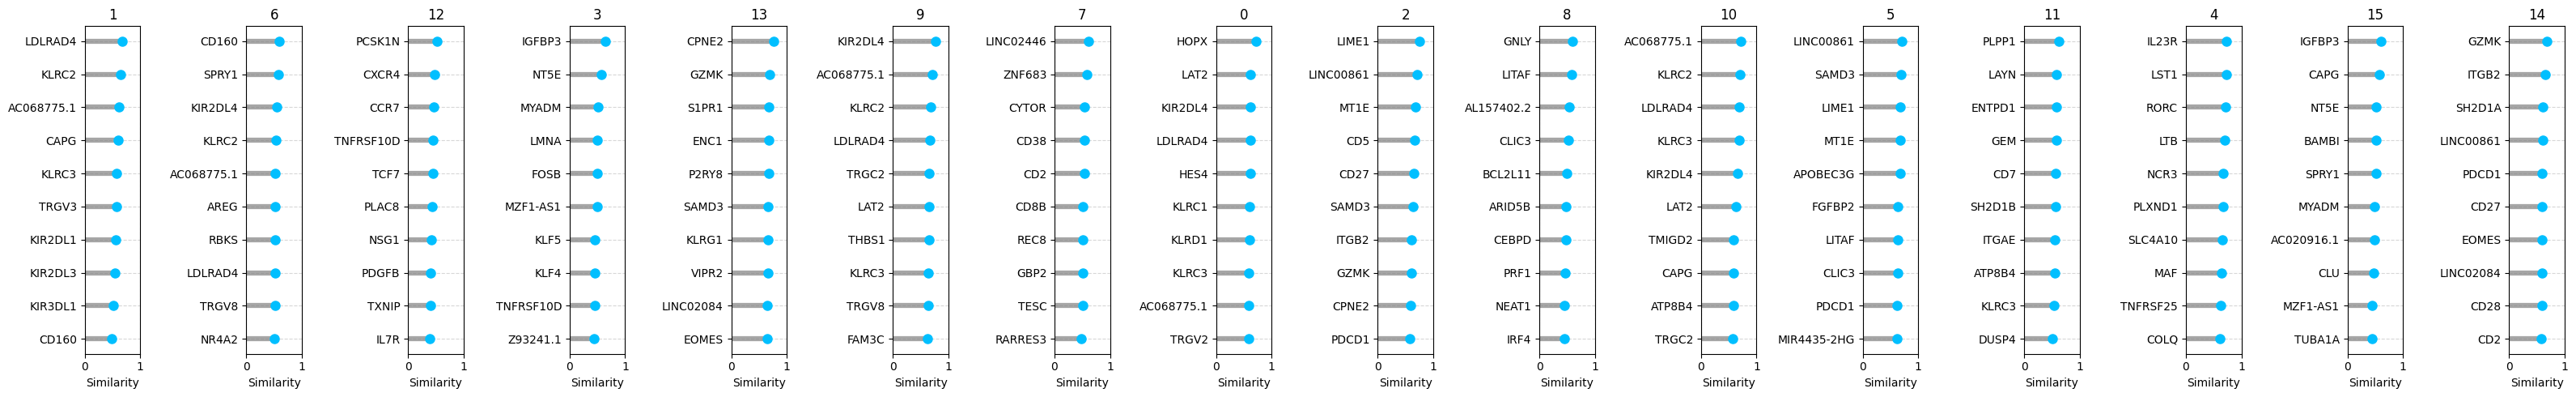

In [293]:
data=[]


import numpy
def get_predictive_genes(self, adata, label, n_genes=10):
    """
    Compute the top n most similar genes to a given variable in the dataset.

    :param adata: anndata object generated from "get_adata", has "X_genevector" in the obsm dataframe.
    :type column: anndata.AnnData
    :param label: Label that defines the cateogies to find predictive genes.
    :type column: str
    :param n_genes: Number of most similar genes to return for each category.
    :type column: int
    :return: The most similar genes to each label stored in a dictionary.
    :rtype:  dict
    """
    vectors = dict()
    mapped_components = dict(zip(list(self.data.keys()),self.matrix))
    comps = collections.defaultdict(list)
    for bc,x in zip(adata.obs.index,adata.obs[label]):
        comps[x].append(mapped_components[bc])
    mean_vecs = []
    for x, vec in comps.items():
        ovecs = []
        vec = numpy.average(vec,axis=0)
        for oph, ovec in comps.items():
            if oph != x:
                ovecs.append(numpy.average(ovec,axis=0))
        aovec = numpy.median(ovecs,axis=0)
        vector = numpy.subtract(vec,aovec)
        vector = numpy.subtract(vector,self.dataset_vector)
        vectors[x] = vector
    markers = dict()
    for x, mvec in vectors.items():
        ct_sig = self.embed.get_similar_genes(mvec)[:n_genes]
        markers[x] = ct_sig
    return markers


for x in get_predictive_genes(cembed,adata,"tcr_cluster").items():
    data.append(x)



# Create a figure with subplots for the modified lollipop plot, ensuring bars are horizontal and enhancing aesthetics
fig, axes = plt.subplots(nrows=1, ncols=len(data), figsize=(2 * len(data), 5))

# If there's only one dataframe, axes might not be an array
if len(data) == 1:
    axes = [axes]

# Customize the color and style for a prettier look
color_point = 'deepskyblue'
color_line = 'gray'

# Generate each lollipop plot
for ax, df in zip(axes, data):
    label = df[0]
    df = df[1]
    # Sort values for better visualization
    df_sorted = df.sort_values('Similarity', ascending=True)
    # Create the lollipop plot: lines + dots
    ax.hlines(y=df_sorted['Gene'], xmin=0, xmax=df_sorted['Similarity'], color=color_line, alpha=0.7, linewidth=4.5)
    ax.plot(df_sorted['Similarity'], df_sorted['Gene'], 'o', color=color_point, markersize=8)
    ax.set_title(label)
    ax.set_xlabel('Similarity')
    ax.set_xlim(0, 1)  # Assuming similarity scores are between 0 and 1
    ax.grid(True, linestyle='--', alpha=0.5)  # Add grid lines for better readability
    ax.set_axisbelow(True)  # Ensure grid lines are below the plot elements

# Adjust layout to avoid tight squeezing of elements
plt.tight_layout()

# Show plot
plt.savefig("/Users/ceglian/markers.pdf")

100%|██████████| 21160/21160 [00:00<00:00, 68329.44it/s]


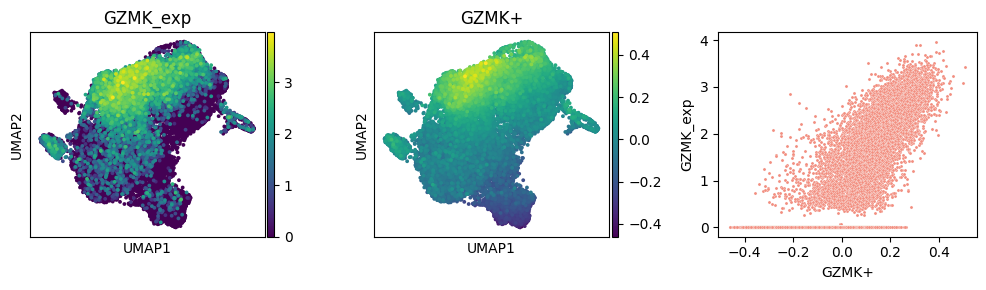

In [368]:
cembed.compare_expression_to_similarity(adata,"GZMK")

In [238]:
def cell_distance(self, vec, norm=True):
    # matrix = self.matrix
    # if norm:
    #     vec /= np.linalg.norm(vec)
    #     print("norm")
    #     matrix = normalize(matrix)
    mapped_components = dict(zip(list(self.data.keys()),self.matrix))
    odists = []
    for x in tqdm.tqdm(self.adata.obs.index):
        cell_vec = mapped_components[x]
        # if norm:
        #     cell_vec /= np.linalg.norm(cell_vec)
        dist = 1. - distance.cosine(cell_vec, vec)
        odists.append(dist)
    return odists

def get_predictive_genes(self, adata, label, n_genes=10):
    """
    Compute the top n most similar genes to a given variable in the dataset.

    :param adata: anndata object generated from "get_adata", has "X_genevector" in the obsm dataframe.
    :type column: anndata.AnnData
    :param label: Label that defines the cateogies to find predictive genes.
    :type column: str
    :param n_genes: Number of most similar genes to return for each category.
    :type column: int
    :return: The most similar genes to each label stored in a dictionary.
    :rtype:  dict
    """
    vectors = dict()
    mapped_components = dict(zip(list(self.data.keys()),self.matrix))
    comps = collections.defaultdict(list)
    for bc,x in zip(adata.obs.index,adata.obs[label]):
        comps[x].append(mapped_components[bc])
    mean_vecs = []
    for x, vec in comps.items():
        ovecs = []
        vec = numpy.average(vec,axis=0)
        for oph, ovec in comps.items():
            if oph != x:
                ovecs.append(numpy.average(ovec,axis=0))
        aovec = numpy.median(ovecs,axis=0)
        vector = numpy.subtract(vec,aovec)
        vector = numpy.subtract(vector,self.dataset_vector)
        vectors[x] = vector
    markers = dict()
    for x, mvec in vectors.items():
        ct_sig = self.embed.get_similar_genes(mvec)[:n_genes]["Gene"].tolist()
        markers[x] = ct_sig
    return markers

In [371]:
for x,y in get_predictive_genes(cembed, adata,"tcr_cluster").items():
    print(x, y)

1 ['KLRC2', 'LDLRAD4', 'AC068775.1', 'KLRC3', 'KIR2DL1', 'KIR2DL3', 'CAPG', 'TRGV3', 'KIR3DL1', 'CD160']
6 ['CD160', 'NR4A2', 'SPRY1', 'NR4A1', 'RBKS', 'AC093010.2', 'NR4A3', 'LDLRAD4', 'KIR2DL4', 'MZF1-AS1']
12 ['PCSK1N', 'CCR7', 'NSG1', 'PLAC8', 'TNFRSF10D', 'TCF7', 'CXCR4', 'IL7R', 'FCMR', 'FAAH2']
3 ['MYADM', 'NT5E', 'IGFBP3', 'FOSB', 'LMNA', 'DUSP1', 'TUBA1A', 'AC020916.1', 'TSC22D3', 'KLF5']
13 ['CPNE2', 'GZMK', 'VIPR2', 'S1PR1', 'KLRG1', 'EOMES', 'LINC02084', 'P2RY8', 'ENC1', 'SAMD3']
9 ['KIR2DL4', 'AC068775.1', 'TRGC2', 'KLRC2', 'LDLRAD4', 'THBS1', 'FAM3C', 'KLRC3', 'LAT2', 'ATP8B4']
7 ['LINC02446', 'ZNF683', 'CD38', 'CD2', 'CYTOR', 'TESC', 'GBP2', 'REC8', 'CD8B', 'GBP5']
0 ['KLRC2', 'LAT2', 'AC068775.1', 'HOPX', 'KLRC3', 'LDLRAD4', 'TRGV2', 'KLRC1', 'KIR2DL4', 'SH2D1B']
2 ['LINC00861', 'LIME1', 'GZMK', 'CD5', 'CPNE2', 'CD27', 'SAMD3', 'ITGB2', 'MT1E', 'SH2D1A']
8 ['GNLY', 'LITAF', 'ARID5B', 'BCL2L11', 'CLIC3', 'AL157402.2', 'NEAT1', 'PRDM1', 'PDCD1', 'PMAIP1']
10 ['AC068775.1'

In [265]:
sc.tl.rank_genes_groups(conga_result,"clusters_gex")

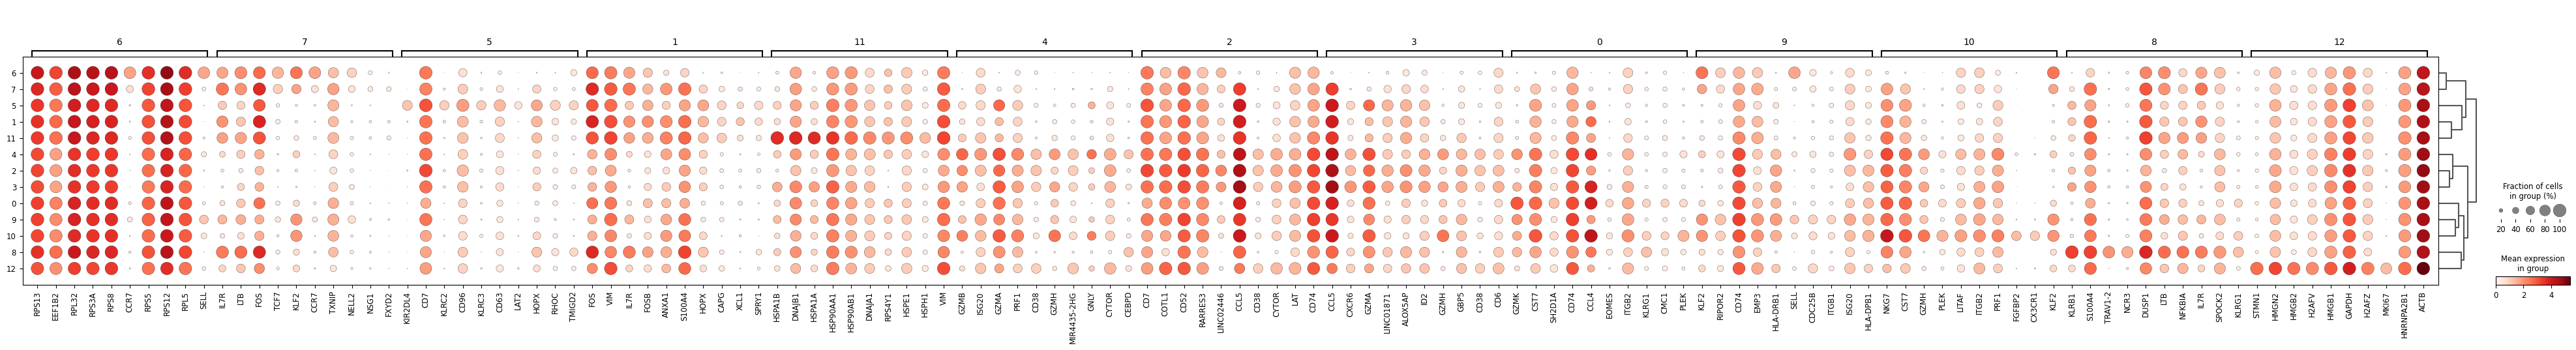

In [268]:
sc.pl.rank_genes_groups_dotplot(conga_result,min_logfoldchange=1)

In [378]:
conga_result.uns['conga_results']['hotspot_features']

Z  pvalue_adj       feature feature_type  nbr_frac
0    483.115994    0.000000  gex_cluster8          gex       0.1
1    446.506611    0.000000          mait          tcr       0.1
2    228.634016    0.000000       SLC4A10          gex       0.1
3    206.388568    0.000000          NCR3          gex       0.1
4    189.149594    0.000000       TRAV1-2          tcr       0.1
..          ...         ...           ...          ...       ...
436    4.621257    0.038966         H3F3A          gex       0.1
437    4.613969    0.040358         MUS81          gex       0.1
438    4.604497    0.042240          FTH1          gex       0.1
439    3.520860    0.043445       TRAV9-2          tcr       0.1
440    4.572784    0.049168          RHOH          gex       0.1

[441 rows x 5 columns]

In [305]:
tcri.pp.register_clonotype_key(adata,"tcr_cluster")

In [306]:
tcri.pp.joint_distribution(adata)

{'PD': '#6A6E75'}


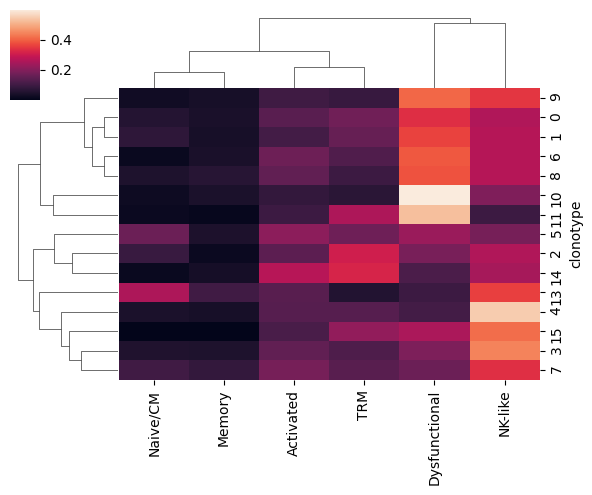

In [315]:
# sub = adata[adata.obs["specificity"] == "MANA"]
# sub = sub[sub.obs["response"] == "MPR"]
sub = adata[adata.obs["clone_size"] > 10]
tcri.pp.joint_distribution(sub)
mat = sub.uns["joint_distribution"] / sub.uns["joint_distribution"].sum(axis=0)
mat = mat.T
df = pd.DataFrame(mat)
mapper = dict(zip(adata.obs["tcr_cluster"],adata.obs["response"]))

rows = []
for x in df.index:
    rows.append(mapper[x])
df["response"] = rows
df = df.sort_values("response")
rows = df.pop("response")
lut = dict(zip(rows.unique(), ["#6A6E75","#A6E22E"]))
print(lut)
row_colors = rows.map(lut)

sns.clustermap(data=df, figsize=(6,5))
plt.savefig("/Users/ceglian/mat.pdf")